# Baselines Predictions

Single Step: https://www.theclickreader.com/single-step-time-series-forecasting/

Baseline Method: https://towardsdatascience.com/baseline-models-your-guide-for-model-building-1ec3aa244b8d

- Persistance Algorith: https://machinelearningmastery.com/persistence-time-series-forecasting-with-python/

# <span style='background :khaki' > Install & Importa Libraries </span>

In [131]:
### ***Enviroment Preparation***
# Install Pandas
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn
!pip install lightgbm

!pip install sktime
!pip install sklego

#!pip install skforecast

# Update pip -- WARNING Resolution
!python.exe -m pip install --upgrade pip

In [132]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from datetime import datetime
from datetime import timedelta

from sklego.preprocessing import RepeatingBasisFunction

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import time
 
# Paths
data = r"C:\Users\ghoyo\Desktop\TFM 3.0\Project\GeneratedDfs\dayly_stational.json"

# Get start time
start_time_infi = time.time()

import warnings
warnings.filterwarnings("ignore")

#### <span style="background:skyblue"> Load Data <span>

In [133]:
df = pd.read_json(data)

In [134]:
TARGET = ['day_n_streams', 'day_n_songs', 'day_new_stream', 'day_new_song']

In [135]:
df = df[TARGET]

#### <span style="background:skyblue"> Little Analysis <span>

Hemos eliminado las 2 valiables que hemos visto que obtenian muy buenos resultados con el método baseline, reduciendo así el tiempo de ejecución y el coste de computo

In [136]:
df[TARGET].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2061 entries, 2017-04-04 to 2022-11-24
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   day_n_streams   2061 non-null   int64
 1   day_n_songs     2061 non-null   int64
 2   day_new_stream  2061 non-null   int64
 3   day_new_song    2061 non-null   int64
dtypes: int64(4)
memory usage: 80.5 KB


In [137]:
df[TARGET].describe()

,day_n_streams,day_n_songs,day_new_stream,day_new_song
count,2061.000000,2061.000000,2061.000000,2061.000000
mean,39.800097,39.741388,6.515284,6.498787
std,28.399624,28.401398,9.862028,9.855146
min,0.000000,0.000000,0.000000,0.000000
25%,20.000000,20.000000,0.000000,0.000000
50%,35.000000,35.000000,3.000000,3.000000
75%,53.000000,53.000000,9.000000,9.000000
max,247.000000,247.000000,106.000000,106.000000


# <span style='background :khaki' > Random Forest Regressor Predictions </span>

### <span style="background:lightgreen"> Functions <span>

<span style="background:violet"> Ranfom Forest Regressor - Function <span>

In [138]:
def tree_feature_importance(df, target, split=7, n_s=100, plot = 0, r = 0, sort = 0):
    # Data
    X = df.drop(target, axis=1)
    y = df[target]
    
    # Split
    X_train, X_test = X.iloc[:-split,:], X.iloc[-split:,:]
    y_train, y_test = y.iloc[:-split], y.iloc[-split:]
    
    # Create - Train - Predict
    model = RandomForestRegressor(n_estimators=n_s)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    
    # Evaluation Methods - MAE & MSE
    mae = np.round(mean_absolute_error(y_test, predictions), 3)    
    mse = np.round(mean_squared_error(y_test, predictions), 3)    
    #print('mae', mae)
    #print('mse', mse)
    
    if plot == 0 or plot == 1:
        # Plot Real Vs Prediction
        fig = plt.figure(figsize=(6,3))
        plt.title(f' {target}: Random Forest Real vs Prediction - MAE {mae}', fontsize=20)
        plt.plot(y_test, color='red')
        plt.plot(pd.Series(predictions, index=y_test.index), color='green')
        plt.xlabel('Dais', fontsize=12)
        plt.ylabel('Number of streams listened', fontsize=12)
        plt.legend(labels=['Real', 'Prediction'], fontsize=12)
        plt.grid()
        plt.show()
    
    # Dataframe with Importance of each feature
    if sort == 0:
        df_importances = pd.DataFrame({
            'feature': df.drop(columns = target).columns,
            'importance': model.feature_importances_}
        ).sort_values(by='importance', ascending=False)
    
    if sort == 1:
        df_importances = pd.DataFrame({
            'feature': df.drop(columns = target).columns,
            'importance': model.feature_importances_}
        )
    
    if plot == 0 or plot == 2:
        # Plot Features Importance
        plt.figure(figsize=(12,8))
        plt.title('Variable Importances', fontsize=12)
        sns.barplot(x=df_importances.importance, y=df_importances.feature, orient='h')
        plt.show()
    
    #  Print Importances
    #print('MAE: ', mae)
    #print(df_importances.sort_values(by='importance'), '\n')
    
    if r == 1:
        return mae, mse, df_importances
    
    return mae, mse

<span style="background:violet"> Ranfom Forest Regressor - TSCV - Function<span>

In [139]:
def tree_feature_importance_cv(df, target, cv_split = 5, test_size = 1, n_s=100, plot = 5, r = 0, sort = 0):
    # Results
    c_predict = []
    c_mae = []
    c_mse = []
    vals = []
    predictions = []
    
    # Data
    X = df.drop(target, axis=1)
    y = df[target]
    
    tscv = TimeSeriesSplit(max_train_size=None, n_splits = cv_split, test_size=test_size)

    # Splti CV Data
    for train_index, test_index in tscv.split(X):
        pre = []
        df_i = []
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        
        # Transformation for a single feature.
        if X_train.shape[1] == 1:
            X_train = X.iloc[train_index].to_numpy().reshape(-1, 1)
            y_train, y_test = y[train_index], y[test_index]
            
        # Transformation for a single sample.
        if test_size == 1:
            X_test = X.iloc[test_index].to_numpy()
            y_train, y_test = y[train_index], y[test_index]
            
            for x in list(X_test):
                model = RandomForestRegressor(n_estimators=n_s)
                model.fit(X_train, y_train)
                yhat = model.predict(x.reshape(1, -1))
                pre.append(yhat)
                
                # Variable Importance
                if sort == 0:
                    df_importances = pd.DataFrame({
                        'feature': df.drop(columns = target).columns,
                        'importance': model.feature_importances_}
                    ).sort_values(by='importance', ascending=False)
    
                if sort == 1:
                    df_importances = pd.DataFrame({
                        'feature': df.drop(columns = target).columns,
                        'importance': model.feature_importances_}
                    )
                
                df_i.append(df_importances)
                vals.append(df_importances['importance'].values)
            
        else:
            print('AUN YO NO SE')

            
        #print('\nX_test 2.0 :', type(X_test),  X_test.shape, X_test)
        #print('\nX_train 2.0:', type(X_train), X_train.shape, X_train)
        #print(df_i)
        
        
        # CV Predict
        c_predict.append(pre)
        c_mse.append(mean_squared_error(y_test, pre))
        c_mae.append(mean_absolute_error(y_test, pre))
        #print('\nCV_MSE = ', c_mse[-1], '-- CV_MAE = ', c_mae[-1])
    
    # Variable Importance mean CV
    mean_i = pd.DataFrame(columns = ['feature', 'importance'])

    for i, cols in zip(range(len(vals[0])), df_importances['feature']):
        aux = []

        for j in range(len(vals)):
            aux.append(vals[j][i])
        
        mean_i.loc[i, 'feature'] = cols
        mean_i.loc[i, 'importance'] = np.mean(aux)
        
    predictions = np.mean(c_predict)
    cv_b_mse = np.mean(c_mse)
    cv_b_mae = np.mean(c_mae)
    
    if plot == 1 or plot == 0 or plot == 4:
        print('\nMSE = ', cv_b_mse)
        print('\nMAE = ', cv_b_mae)
    
    if plot == 2 or plot == 4:
        print('\n Predictions: \n', c_predict)
    
    if plot == 3 or plot == 0 or plot == 4:
        print('\n VI\n', mean_i)

    # Create - Train - Predict

    if r == 0:
        return cv_b_mae, cv_b_mse, mean_i
    
    if r == 1:
        return cv_b_mae, cv_b_mse, mean_i, predictions
    
    if r == 2:
        return cv_b_mae, cv_b_mse

<span style="background:violet"> Ranfom Forest Regressor - BCV - Function<span>

In [140]:
def tree_feature_importance_bcv(df, target, test_size = 1, cv_split = 5, n_s=100, plot = 5, r = 0, sort = 0):
    # Results
    c_predict = []
    c_mae = []
    c_mse = []
    vals = []
    predictions = []
    
    # Data
    X = df.drop(target, axis=1)
    y = df[target]
    
    tscv = BlockingTimeSeriesSplit(n_splits = cv_split)

    # Splti CV Data
    for train_index, test_index in tscv.split(X):
        pre = []
        df_i = []
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        
        # Transformation for a single feature.
        if X_train.shape[1] == 1:
            X_train = X.iloc[train_index].to_numpy().reshape(-1, 1)
            y_train, y_test = y[train_index], y[test_index]
            
        # Transformation for a single sample.
        if test_size == 1:
            X_test = X.iloc[test_index].to_numpy()
            y_train, y_test = y[train_index], y[test_index]
            
            for x in list(X_test):
                model = RandomForestRegressor(n_estimators=n_s)
                model.fit(X_train, y_train)
                yhat = model.predict(x.reshape(1, -1))
                pre.append(yhat)
                
                # Variable Importance
                if sort == 0:
                    df_importances = pd.DataFrame({
                        'feature': df.drop(columns = target).columns,
                        'importance': model.feature_importances_}
                    ).sort_values(by='importance', ascending=False)
    
                if sort == 1:
                    df_importances = pd.DataFrame({
                        'feature': df.drop(columns = target).columns,
                        'importance': model.feature_importances_}
                    )
                
                df_i.append(df_importances)
                vals.append(df_importances['importance'].values)
            
        else:
            print('AUN YO NO SE')

            
        #print('\nX_test 2.0 :', type(X_test),  X_test.shape, X_test)
        #print('\nX_train 2.0:', type(X_train), X_train.shape, X_train)
        #print(df_i)
        
        
        # CV Predict
        c_predict.append(pre)
        c_mse.append(mean_squared_error(y_test, pre))
        c_mae.append(mean_absolute_error(y_test, pre))
        #print('\nCV_MSE = ', c_mse[-1], '-- CV_MAE = ', c_mae[-1])
    
    # Variable Importance mean CV
    mean_i = pd.DataFrame(columns = ['feature', 'importance'])

    for i, cols in zip(range(len(vals[0])), df_importances['feature']):
        aux = []

        for j in range(len(vals)):
            aux.append(vals[j][i])
        
        mean_i.loc[i, 'feature'] = cols
        mean_i.loc[i, 'importance'] = np.mean(aux)
        
    predictions.append(c_predict)
    cv_b_mse = np.mean(c_mse)
    cv_b_mae = np.mean(c_mae)
    
    if plot == 1 or plot == 0 or plot == 4:
        print('\nMSE = ', cv_b_mse)
        print('\nMAE = ', cv_b_mae)
    
    if plot == 2 or plot == 4:
        print('\n Predictions: \n', c_predict)
    
    if plot == 3 or plot == 0 or plot == 4:
        print('\n VI\n', mean_i)

    # Create - Train - Predict

    if r == 0:
        return cv_b_mae, cv_b_mse, mean_i
    
    if r == 1:
        return cv_b_mae, cv_b_mse, mean_i, predictions
    
    if r == 2:
        return cv_b_mae, cv_b_mse

<span style='background :violet' > Global Variables for simulation and cross validation </span>

In [141]:
n_sims = 75
n_splits = 14

n_sims_cv = 75
n_splits_cv = 14

### <span style='background :lightgreen' > Generate Lags and Select a number of Lags </span>

#### <span style='background :skyblue' > Generate Lags for better predictions </span>

Creating lagged dataframes to inspect with the studied information of Autocorrelation and Partial Autocorrelation

As we have studied Autocorrelation and Partial-Autocorrelation for all variables we can see best posible options for each variable:  

Partial Autocorrelation <br/>
- day_n_stream = from 5 to 8 <br/>
- day_new_stream = from 3 to 8 <br/>
- day_n_song = same ass n_streams <br/>
- day_new_song = same as new_stream <br/>

We remove this variables because the baseline method already haves awesome results
- day_n_podcast = 1 or 2<br/>
- day_new_podcast = 1 <br/>

https://stackoverflow.com/questions/48818213/make-multiple-shifted-lagged-columns-in-pandas
    
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html
        
https://www.geeksforgeeks.org/what-does-the-double-star-operator-mean-in-python/

In [142]:
%%time 

df_list = []
X_list = []
y_list = []

for i in TARGET:
    autocorr = 8
    l_df_var = []
    X_aux = []
    y_aux = []
    lags = range(1, autocorr+1)
    
    for la in lags:
        # Create List of lags for dataframe
        df_tr_var = df[i].copy().to_frame()
        df_tr_var = df_tr_var.assign(**{f'{col} (t-{l})': df[col].shift(l) for l in range(1, la+1) for col in df_tr_var})
        df_tr_var.dropna(inplace=True)
        l_df_var.append(df_tr_var)
        
        # Create list of Data for dataframe
        X = df_tr_var[df_tr_var.columns[1:]]
        y = df_tr_var[df_tr_var.columns[0]].to_frame()
        X_aux.append(X)
        y_aux.append(y)
        
    #l_df_var[7].head(1)
    df_list.append(l_df_var)
    X_list.append(X_aux)
    y_list.append(y_aux)

CPU times: total: 93.8 ms
Wall time: 107 ms


#### <span style='background :skyblue' > Variable Importance Overview </span>

DATAFRAME:  day_n_streams -- Last Lag ------------------------------------


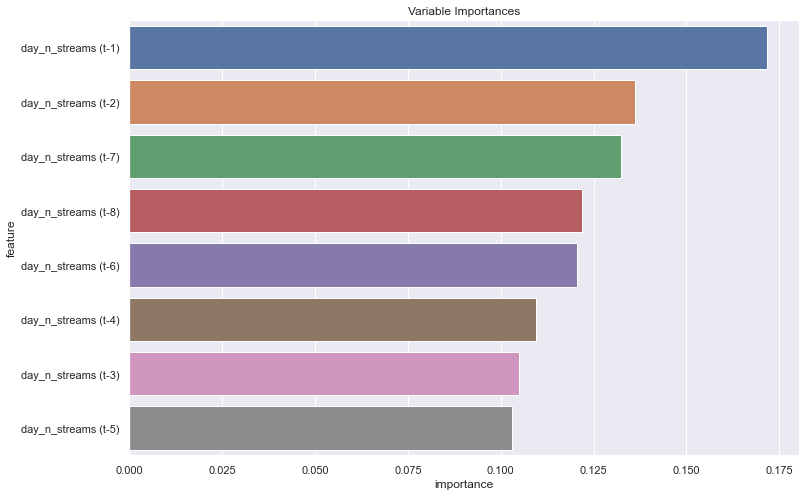

DATAFRAME:  day_n_songs -- Last Lag ------------------------------------


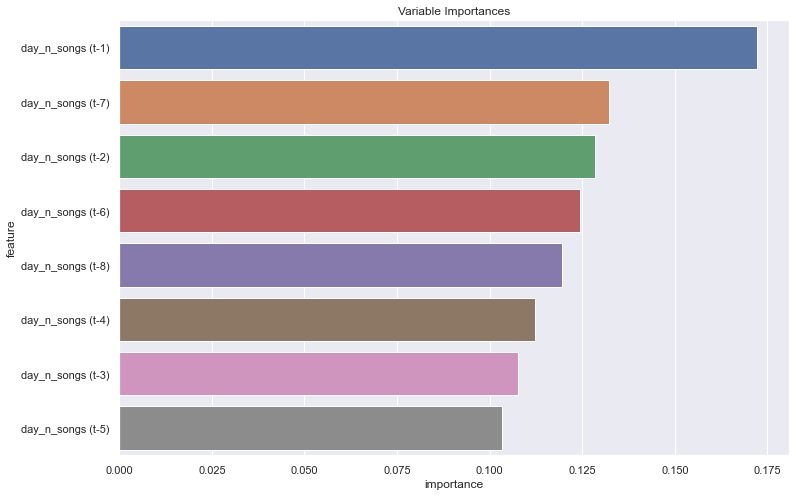

DATAFRAME:  day_new_stream -- Last Lag ------------------------------------


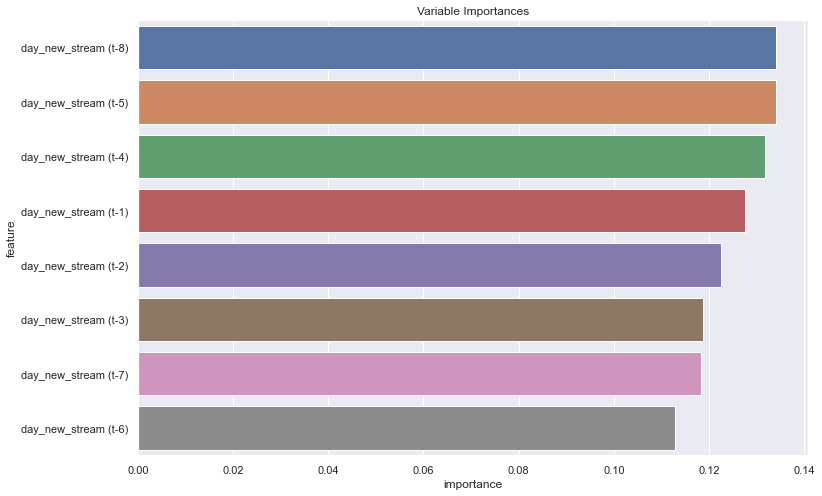

DATAFRAME:  day_new_song -- Last Lag ------------------------------------


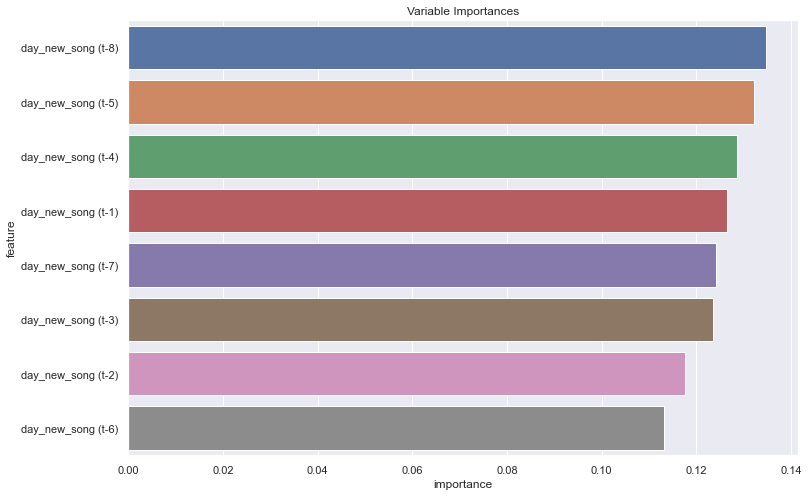

CPU times: total: 4.22 s
Wall time: 4.6 s


In [143]:
%%time

for d in df_list:
    print('DATAFRAME: ', d[-1].columns[0], '-- Last Lag ------------------------------------')
    target = d[-1].columns[0]
    tree_feature_importance(d[-1], target, split=1, plot = 2, r = 1, sort=0)

### <span style='background :lightgreen' > Base - Random Forest Simulation </span>

In [144]:
%%time

start_full = time.time()
times_s = []
times_e = []

df_mae = []
df_mse = []
df_var_i = []

for d in df_list:
    start = time.time()
    times_s.append(start)
    
    lag_mae = []
    lag_mse = []
    lag_vi = []

    # Diferent Lags Loop
    for df_vi, lag_i in zip(d, range(len(d))):
        sim_mae = []
        sim_mse = []
        sim_vi = []
        
        target = df_vi.columns[0]
        
        # Simulation Loop
        for sim in range(n_sims):
            #print('-- Sim Nº', sim, '--\n')
            mae , mse, vi = tree_feature_importance(df_vi, target, split=n_splits, plot = 3, r = 1)
        
            # Save data -- SIM
            sim_mae.append(mae)
            sim_mse.append(mse)
            sim_vi.append(vi)
        
            #print('mae = ', mae)
            #print('mse = ', mse)
            #print('vi -- \n', vi, '\n')
            #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
        #print('\n\nMean Evaluation LAGS ', lag_i , ' METRICS')
        #print('MAE ', np.mean(sim_mae))
        #print('MSE ', np.mean(sim_mse))

        mean_sim_vi = pd.DataFrame(columns = ['feature', 'importance'])
    
        # Loop to make variable importance simulation mean
        for i,col in zip(range(sim_vi[0].shape[0]), sim_vi[0]['feature']):
            aux = []
    
            for j in range(n_sims):
                aux.append(sim_vi[j]['importance'][i])
    
            mean_sim_vi.loc[i, 'feature'] = col
            mean_sim_vi.loc[i, 'importance'] = np.mean(aux)

        #print('\n Mean Variable Importance LAGS DATAFRAMES \n')
        #mean_sim_vi.head()
    
        # Save Data -- LAG Loop
        lag_mae.append(np.mean(sim_mae))
        lag_mse.append(np.mean(sim_mse))
        lag_vi.append(mean_sim_vi)
    
    # Save Data -- VARIABLES/FEATURES

    #print(lag_mae)
    #print(lag_mse)
    #print(lag_vi)
    
    df_mae.append(lag_mae)
    df_mse.append(lag_mse)
    df_var_i.append(lag_vi)
    
    end = time.time()
    times_e.append(end)
    
end_full = time.time()

CPU times: total: 15min 2s
Wall time: 33min 25s


In [145]:
print("full time: ", end_full-start_full * 10**3, 'ms')
for s, e in zip(times_s, times_e):
    print("part_time: ", e-s*10**3, 'ms')

full time:  -1679111748246.0774 ms
part_time:  -1679111749885.2969 ms
part_time:  -1679112115616.5105 ms
part_time:  -1679112717534.1433 ms
part_time:  -1679113244051.8667 ms


In [146]:
for a,e,i in zip(df_mae, df_mse, df_var_i):
    print(a)
    print(e, '\n')
    # print(i, '\n')

#print(df_mae)
#print(df_mse)
#print(df_vi)

[24.754546666666663, 21.348146666666672, 23.786640000000002, 22.004880000000004, 22.220613333333333, 21.69472, 21.895226666666666, 22.433933333333336]
[804.5227600000001, 651.2407466666666, 836.8406933333333, 686.4733466666667, 667.6297999999999, 640.58992, 660.5141333333333, 701.7745733333334] 

[23.967293333333334, 22.181626666666666, 22.091613333333335, 22.197533333333332, 21.763093333333334, 21.489880000000003, 22.131093333333336, 22.677373333333335]
[743.3247866666666, 728.66072, 709.4612, 706.5943466666666, 644.7516933333334, 636.9448666666666, 677.3634533333333, 716.4452800000001] 

[5.324866666666667, 4.41908, 4.680293333333333, 7.005186666666667, 4.61436, 4.284186666666667, 5.4085866666666655, 4.6239333333333335]
[35.57966666666667, 29.55696, 28.21005333333333, 101.61714666666667, 31.718000000000004, 23.29781333333334, 42.687360000000005, 33.359626666666664] 

[5.341506666666667, 4.417786666666666, 4.853293333333332, 7.534613333333334, 4.806853333333334, 4.437546666666667, 5.3

In [147]:
for i in df_var_i:
    for j in i:
        print(j)
        print('--------------------------------------')

               feature importance
0  day_n_streams (t-1)        1.0
--------------------------------------
               feature importance
0  day_n_streams (t-1)   0.504388
1  day_n_streams (t-2)   0.495612
--------------------------------------
               feature importance
0  day_n_streams (t-1)   0.352328
1  day_n_streams (t-2)   0.332326
2  day_n_streams (t-3)   0.315346
--------------------------------------
               feature importance
0  day_n_streams (t-1)   0.287287
1  day_n_streams (t-2)   0.248506
2  day_n_streams (t-4)   0.230954
3  day_n_streams (t-3)   0.233254
--------------------------------------
               feature importance
0  day_n_streams (t-1)   0.243853
1  day_n_streams (t-2)   0.204378
2  day_n_streams (t-4)    0.18249
3  day_n_streams (t-3)   0.189316
4  day_n_streams (t-5)   0.179962
--------------------------------------
               feature importance
0  day_n_streams (t-1)   0.213059
1  day_n_streams (t-2)   0.170254
2  day_n_streams (t-6) 

### <span style='background :lightgreen' > Cross Validation  </span>

#### <span style='background :skyblue' > TSCV </span>

In [148]:
%%time

start_full_tscv = time.time()
times_s_tscv = []
times_e_tscv = []

df_mae_tscv = []
df_mse_tscv = []
df_var_i_tscv = []


for d in df_list:
    start = time.time()
    times_s_tscv.append(start)

    lag_mae_tscv = []
    lag_mse_tscv = []
    lag_vi_tscv = []

    # Diferent Lags Loop
    for df_vi, lag_i in zip(d, range(len(d))):
        sim_mae_tscv = []
        sim_mse_tscv = []
        sim_vi_tscv = []
        
        target = df_vi.columns[0]
        
        # Simulation Loop
        for sim in range(n_sims_cv):
            #print('-- Sim Nº', sim, '--\n')
            mae_tscv , mse_tscv, vi_tscv = tree_feature_importance_cv(df_vi, target = df_vi.columns[0], cv_split=n_splits_cv, r = 0)
        
            # Save data -- SIM
            sim_mae_tscv.append(mae_tscv)
            sim_mse_tscv.append(mse_tscv)
            sim_vi_tscv.append(vi_tscv)
        
            #print('mae = ', mae)
            #print('mse = ', mse)
            #print('vi -- \n', vi, '\n')
            #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
        #print('\n\nMean Evaluation LAGS ', lag_i , ' METRICS')
        #print('MAE ', np.mean(sim_mae))
        #print('MSE ', np.mean(sim_mse))

        mean_sim_vi_tscv = pd.DataFrame(columns = ['feature', 'importance'])
    
        # Loop to make variable importance simulation mean
        for i,col in zip(range(sim_vi_tscv[0].shape[0]), sim_vi_tscv[0]['feature']):
            aux = []
    
            for j in range(n_sims):
                aux.append(sim_vi_tscv[j]['importance'][i])
    
            mean_sim_vi_tscv.loc[i, 'feature'] = col
            mean_sim_vi_tscv.loc[i, 'importance'] = np.mean(aux)

        #print('\n Mean Variable Importance LAGS DATAFRAMES \n')
        #mean_sim_vi.head()
    
        # Save Data -- LAG Loop
        lag_mae_tscv.append(np.round(np.mean(sim_mae_tscv), 3))
        lag_mse_tscv.append(np.round(np.mean(sim_mse_tscv), 3))
        lag_vi_tscv.append(mean_sim_vi_tscv)
    
    # Save Data -- VARIABLES/FEATURES

    #print(lag_mae)
    #print(lag_mse)
    #print(lag_vi)
    
    df_mae_tscv.append(lag_mae_tscv)
    df_mse_tscv.append(lag_mse_tscv)
    df_var_i_tscv.append(lag_vi_tscv)    
    
    end = time.time()
    times_e_tscv.append(end)
    
end_full_tscv = time.time()

CPU times: total: 4h 33min 14s
Wall time: 5h 30min 35s


In [149]:
print("full time: ", end_full-start_full * 10**3, 'ms')
for s, e in zip(times_s, times_e):
    print("part_time: ", e-s*10**3, 'ms')

full time:  -1679111748246.0774 ms
part_time:  -1679111749885.2969 ms
part_time:  -1679112115616.5105 ms
part_time:  -1679112717534.1433 ms
part_time:  -1679113244051.8667 ms


In [150]:
for a,e,i in zip(df_mae_tscv, df_mse_tscv, df_var_i_tscv):
    print(a)
    print(e, '\n')
    # print(i, '\n')

#print(df_mae)
#print(df_mse)
#print(df_vi)

[24.528, 21.574, 23.488, 22.163, 22.009, 21.577, 21.816, 22.332]
[799.881, 661.113, 829.586, 712.626, 663.408, 635.272, 663.162, 694.759] 

[23.736, 22.358, 22.101, 22.068, 21.502, 21.52, 22.054, 22.561]
[737.859, 734.328, 723.154, 707.701, 639.334, 641.487, 675.728, 717.878] 

[5.315, 4.425, 4.701, 7.056, 4.592, 4.339, 5.375, 4.628]
[35.487, 29.519, 28.632, 103.034, 31.25, 23.64, 42.018, 34.224] 

[5.337, 4.438, 4.843, 7.47, 4.833, 4.422, 5.292, 4.696]
[36.179, 29.979, 30.004, 103.926, 32.948, 25.134, 42.342, 37.719] 



#### <span style='background :skyblue' > BCV </span>

In [151]:
class BlockingTimeSeriesSplit():
    def __init__(self, n_splits):
        self.n_splits = n_splits
    
    def get_n_splits(self, X, y, groups):
        return self.n_splits
    
    def split(self, X, y=None, groups=None):
        n_samples = len(X)
        k_fold_size = n_samples // self.n_splits
        indices = np.arange(n_samples)

        margin = 0
        for i in range(self.n_splits):
            start = i * k_fold_size
            stop = start + k_fold_size
            mid = int(0.999999 * (stop - start)) + start
            yield indices[start: mid], indices[mid + margin: stop]

In [152]:
%%time

start_full_bcv = time.time()
times_s_bcv = []
times_e_bcv = []

df_mae_bcv = []
df_mse_bcv = []
df_var_i_bcv = []

for d in df_list:
    start = time.time()
    times_s_bcv.append(start)
    
    lag_mae_bcv = []
    lag_mse_bcv = []
    lag_vi_bcv = []
    
    # Diferent Lags Loop
    for df_vi, lag_i in zip(d, range(len(d))):
        sim_mae_bcv = []
        sim_mse_bcv = []
        sim_vi_bcv = []
        
        target_bcv = df_vi.columns[0]
        
        # Simulation Loop
        for sim in range(n_sims_cv):
            #print('-- Sim Nº', sim, '--\n')
            mae_bcv , mse_bcv, vi_bcv = tree_feature_importance_bcv(df_vi, target = df_vi.columns[0], cv_split=n_splits_cv, r = 0)
        
            # Save data -- SIM
            sim_mae_bcv.append(mae_bcv)
            sim_mse_bcv.append(mse_bcv)
            sim_vi_bcv.append(vi_bcv)
        
            #print('mae = ', mae)
            #print('mse = ', mse)
            #print('vi -- \n', vi, '\n')
            #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
        #print('\n\nMean Evaluation LAGS ', lag_i , ' METRICS')
        #print('MAE ', np.mean(sim_mae))
        #print('MSE ', np.mean(sim_mse))

        mean_sim_vi_bcv = pd.DataFrame(columns = ['feature', 'importance'])
    
        # Loop to make variable importance simulation mean
        for i,col in zip(range(sim_vi_bcv[0].shape[0]), sim_vi_bcv[0]['feature']):
            aux = []
    
            for j in range(n_sims):
                aux.append(sim_vi_bcv[j]['importance'][i])
    
            mean_sim_vi_bcv.loc[i, 'feature'] = col
            mean_sim_vi_bcv.loc[i, 'importance'] = np.mean(aux)

        #print('\n Mean Variable Importance LAGS DATAFRAMES \n')
        #mean_sim_vi.head()
    
        # Save Data -- LAG Loop
        lag_mae_bcv.append(np.round(np.mean(sim_mae_bcv), 3))
        lag_mse_bcv.append(np.round(np.mean(sim_mse_bcv), 3))
        lag_vi_bcv.append(mean_sim_vi_bcv)
    
    # Save Data -- VARIABLES/FEATURES

    #print(lag_mae)
    #print(lag_mse)
    #print(lag_vi)
    
    df_mae_bcv.append(lag_mae_bcv)
    df_mse_bcv.append(lag_mse_bcv)
    df_var_i_bcv.append(lag_vi_bcv)    
    
    end = time.time()
    times_e_bcv.append(end)
    
end_full_bcv = time.time()

CPU times: total: 1h 8s
Wall time: 1h 28s


In [153]:
print("full time: ", end_full_bcv-start_full_bcv * 10**3, 'ms')
for s, e in zip(times_s_bcv, times_e_bcv):
    print("part_time: ", e-s*10**3, 'ms')

full time:  -1679133566803.0842 ms
part_time:  -1679133569503.906 ms
part_time:  -1679134499395.3323 ms
part_time:  -1679135432523.469 ms
part_time:  -1679136308555.5247 ms


In [154]:
for a,e,i in zip(df_mae_bcv, df_mse_bcv, df_var_i_bcv):
    print(a)
    print(e, '\n')
    # print(i, '\n')

#print(df_mae)
#print(df_mse)
#print(df_vi)

[22.883, 16.12, 28.185, 16.667, 19.356, 21.184, 16.811, 33.006]
[819.233, 410.846, 1366.259, 425.241, 586.643, 893.212, 381.166, 1460.626] 

[22.747, 17.755, 28.024, 15.895, 19.496, 20.373, 17.078, 32.409]
[814.501, 476.317, 1335.797, 400.753, 621.277, 865.106, 390.293, 1422.949] 

[5.503, 6.692, 4.856, 7.159, 5.569, 5.11, 8.349, 8.029]
[51.379, 85.019, 47.131, 121.856, 53.936, 36.038, 96.931, 107.805] 

[5.459, 6.734, 4.683, 7.418, 5.662, 5.135, 8.389, 8.095]
[50.984, 83.992, 46.033, 124.47, 56.395, 36.35, 98.118, 110.475] 



# <span style='background :Beige' > For Computation Reason we compare and select the best CV Model </span>

In [155]:
# Studying mean MAES VALUES 

In [156]:
print('Full TSCV Mean: ', np.mean(df_mae_tscv))
print('Full BCV Mean: ', np.mean(df_mae_bcv))

if(np.mean(df_mae_tscv) >= np.mean(df_mae_bcv)):
    print('Best Average Mean MAE == BCV')
else:
    print('Best Average Mean MAE == TSCV')
    
counts = 0
for a,e,i in zip(df_mae_tscv, df_mae_bcv):
    print('Partial TSCV Mean: ', np.mean(df_mae_tscv))
    print('Partial BCV Mean: ', np.mean(df_mae_bcv))
    if(np.mean(df_mae_tscv) >= np.mean(df_mae_bcv)):
        counts = counts+1
    else:
        counts = counts-1
        
print(counts)
if(counts >= 0):
    print('Best Option = BCV')
else:
    print('Best Option = TSCV')

Full TSCV Mean:  13.72340625
Full BCV Mean:  14.08846875
Best Average Mean MAE == TSCV


ValueError: not enough values to unpack (expected 3, got 2)

In [ ]:
# Studying mean MSE VALUES 

In [ ]:
print('Full TSCV Mean: ', np.mean(df_mse_tscv))
print('Full BCV Mean: ', np.mean(df_mse_bcv))

if(np.mean(df_mse_tscv) >= np.mean(df_mse_bcv)):
    print('Best Average Mean MSE == BCV')
else:
    print('Best Average Mean MSE == TSCV')

counts = 0
for a,e,i in zip(df_mse_tscv, df_mse_bcv):
    print('Partial TSCV Mean: ', np.mean(df_mse_tscv))
    print('Partial BCV Mean: ', np.mean(df_mse_bcv))
    if(np.mean(df_mse_tscv) >= np.mean(df_mse_bcv)):
        counts = counts+1
    else
        counts = counts-1
        
print(counts)
if(counts >= 0):
    print('Best Option = BCV')
else:
    print('Best Option = TSCV')

In [ ]:
# Studying times

In [ ]:
full_tscv = end_full_tscv-start_full_tscv
full_bcv = end_full_bcv-start_full_bcv

print("full time TSCV: ", full_tscv * 10**3, 'ms')
print("full time BCV: ", full_bcv * 10**3, 'ms')

if(full_tscv = full_bcv):
    print('Best Average Mean Time == BCV')
else:
    print('Best Average Mean Time == TSCV')
    
partial_tscv = []
partial_bcv = []

for s, e in zip(times_s_tscv, times_e_tscv):
    partial_tscv.append(e-s)
    
for s, e in zip(times_s_bcv, times_e_bcv):
    partial_bcv.append(e-s)
    
counts = 0
for t, b in zip(partial_tscv, partial_bcv):
    print('TSCV time = ', t*10**3, 'ms')
    print('BCV time = ', b*10**3, 'ms')
    if(t >= b):
        counts = counts+1
    else
        counts = counts-1
    
print(counts)
if(counts >= 0):
    print('Best Option = BCV')
else:
    print('Best Option = TSCV')

# <span style='background :Beige' > New DFs List with best Lags Selected </span>

#### <span style='background :skyblue' > Studie Best Values each model predictions </span>

<span style='background :violet' >Original Predict -- Select Best Mae & Mse Result = NºLags for each DF Variable  </span>

In [ ]:
best_res_mae = []
best_res_mse = []
ix_lags_mae = []
ix_lags_mse = []

# Block Cross Validation
for d, mae, mse in zip(df_list, df_mae, df_mse):
    best_res_mae.append(min(mae))
    best_res_mse.append(min(mse))
    
    ix_lags_mae.append(mae.index(min(mae)))
    ix_lags_mse.append(mse.index(min(mse)))

    print(str(d[ix_lags_mae[-1]].columns[0]), ': \n\t - MAE: ix = ', ix_lags_mae[-1], ' --- val = ', best_res_mae[-1],
         '\n\t - MSE: ix = ', ix_lags_mse[-1], ' --- val = ', best_res_mse[-1])

<span style='background :violet' >TSCV -- Select Best Mae & Mse Result = NºLags for each DF Variable  </span>

In [ ]:
best_res_mae_tscv = []
best_res_mse_tscv = []
ix_lags_mae_tscv = []
ix_lags_mse_tscv = []

# Block Cross Validation
for d, mae, mse in zip(df_list, df_mae_tscv, df_mse_tscv):
    best_res_mae_tscv.append(min(mae))
    best_res_mse_tscv.append(min(mse))
    
    ix_lags_mae_tscv.append(mae.index(min(mae)))
    ix_lags_mse_tscv.append(mse.index(min(mse)))

    print(str(d[ix_lags_mae_tscv[-1]].columns[0]), ': \n\t - MAE: ix = ', ix_lags_mae_tscv[-1], ' --- val = ', best_res_mae_tscv[-1],
         '\n\t - MSE: ix = ', ix_lags_mse_tscv[-1], ' --- val = ', best_res_mse_tscv[-1])

<span style='background :violet' >BCV -- Select Best Mae & Mse Result = NºLags for each DF Variable  </span>

In [ ]:
best_res_mae_bcv = []
best_res_mse_bcv = []
ix_lags_mae_bcv = []
ix_lags_mse_bcv = []

# Block Cross Validation
for d, mae, mse in zip(df_list, df_mae_bcv, df_mse_bcv):
    best_res_mae_bcv.append(min(mae))
    best_res_mse_bcv.append(min(mse))
    
    ix_lags_mae_bcv.append(mae.index(min(mae)))
    ix_lags_mse_bcv.append(mse.index(min(mse)))

    print(str(d[ix_lags_mae_bcv[-1]].columns[0]), ': \n\t - MAE: ix = ', ix_lags_mae_bcv[-1], ' --- val = ', best_res_mae_bcv[-1],
         '\n\t - MSE: ix = ', ix_lags_mse_bcv[-1], ' --- val = ', best_res_mse_bcv[-1])

#### <span style='background :skyblue' > Compare Global Results -- Mostly Caring About </span>

In [ ]:
best_mae_res = []
best_mse_res = []
ix_lags_mae = []
ix_lags_mse = []
whoswhomae = []
whoswhomse = []


for d, mae_tscv, mse_tscv, mae_bcv, mse_bcv in zip(df_list, df_mae_tscv, df_mse_tscv, df_mae_bcv, df_mse_bcv):
    
    # Saving Best of all Mae Results and Index
    if(min(mae_tscv) <= min(mae_bcv)):
        best_mae_res.append(min(mae_tscv))
        ix_lags_mae.append(mae_tscv.index(min(mae_tscv)))
        whoswhomae.append('tscv')
        
    elif(min(mae_tscv) > min(mae_bcv)):
        best_mae_res.append(min(mae_bcv))
        ix_lags_mae.append(mae_bcv.index(min(mae_bcv)))
        whoswhomae.append('bcv')
        
    # Saving Best of all Mse Results and Index
    if(min(mse_tscv) <= min(mse_bcv)):
        best_mse_res.append(min(mse_tscv))
        ix_lags_mse.append(mse_tscv.index(min(mse_tscv)))
        whoswhomse.append('tscv')
        
    elif(min(mse_tscv) > min(mse_bcv)):
        best_mse_res.append(min(mse_bcv))
        ix_lags_mse.append(mse_bcv.index(min(mse_bcv)))
        whoswhomse.append('bcv')
        
    # Print Best Results and Indexes
    print(str(d[ix_lags_mae[-1]].columns[0]), ': \n\t', whoswhomae[-1], '- MAE: ix = ', ix_lags_mae[-1], ' --- val = ', best_mae_res[-1],
         '\n\t', whoswhomse[-1], '- MSE: ix = ', ix_lags_mse[-1], ' --- val = ', best_mse_res[-1])
    
    

# <span style='background :yellow' > Search Why Better or why we ussing MAE insted of MSE </span>


# <span style='background :yellow' > Compare Execution Time: TSCV Gets Better Results but in Execution and computation time BCV is much better 7 min to 22 min of tscv </span>


<span style='background :orange' > Who is worth and why ? </span>


#### <span style='background :skyblue' > Generate New Df List with the best lags assigned </span>

In [ ]:
df_list_best_lags = []

for d, i in zip(df_list, ix_lags_mae):
    print(i)
    df_list_best_lags.append(d[i])
    print(d[i])

In [ ]:
df_list_best_lags

In [ ]:
df_list_best_lags[1].head(2)

<span style='background :violet' > Some Theory </span>

<span style='background :yellow' >Generate Lags for better predictions - VI.- VARIABLE IMPORTANCE

<span style='background :yellow' >Creating lagged dataframes to inspect with the studied information of Autocorrelation and Partial Autocorrelation


- <span style='background :yellow' > As we have studied Autocorrelation and Partial-Autocorrelation for all variables we can see best posible options for each variable:

<span style='background :yellow' >Partial Autocorrelation <br/>
 - <span style='background :yellow' >day_n_stream = from 5 to 8 <br/>
 - <span style='background :yellow' >day_new_stream = from 3 to 8 <br/>
 - <span style='background :yellow' >day_n_song = same ass n_streams <br/>
 - <span style='background :yellow' >day_new_song = same as new_stream <br/>

<span style='background :yellow' >We remove this variables because the baseline method already haves awesome results
- <span style='background :yellow' >day_n_podcast = 1 or 2<br/>
- <span style='background :yellow' >day_new_podcast = 1 <br/> </span>

https://stackoverflow.com/questions/48818213/make-multiple-shifted-lagged-columns-in-pandas
    
https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.assign.html
        
https://www.geeksforgeeks.org/what-does-the-double-star-operator-mean-in-python/

# <span style='background :Beige' > Time Features </span>

### <span style='background :lightgreen' > Functions  </span>

<span style='background :violet' > Multiple TF - Function </span>

In [ ]:
def create_time_features(df, f=0):
    df = df.copy()
    if f == 0:
        df['year'] = df.index.year
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['week'] = df.index.isocalendar().week
        df['day'] = df.index.day
        df['dayofyear'] = df.index.dayofyear
        df['dayofweek'] = df.index.dayofweek
    
        df['is_month_end'] = df.index.is_month_end
        df['is_month_start'] = df.index.is_month_start
        df['is_cuarter_end'] = df.index.is_quarter_end
        df['is_cuarter_start'] = df.index.is_quarter_start
        df['is_year_start'] = df.index.is_year_start
    
    if f == 1:
        df['year'] = df.index.year
        df['quarter'] = df.index.quarter
        df['month'] = df.index.month
        df['week'] = df.index.isocalendar().week
        df['day'] = df.index.day
        df['dayofyear'] = df.index.dayofyear
        df['dayofweek'] = df.index.dayofweek
        
    if f == 2:
        df['day'] = df.index.day
        df['dayofyear'] = df.index.dayofyear
        df['dayofweek'] = df.index.dayofweek
        df['year'] = df.index.year
        
        
    return df

<span style='background :yellow' > 1.1.1.- Funcion que seleccion X numero de variables según un threshold de importancia </span>

Por ejemplo: 
   - solo las variables que su VI >= 0.1
   - Sumar VI de Variables, de mas importante a menos, hasta llegar a un VI_TOTAL >= 0.8 

### <span style='background :lightgreen' > Generate TF to the Best Lag Dataframes  </span>

In [ ]:
# Create Time Features List - Splitt because it is more visual.
df_list_tf0 = []
df_list_tf1 = []
df_list_tf2 = []

In [ ]:
# Generate Time Features
for d in df_list_best_lags:
    df_list_tf0.append(create_time_features(d))
    df_list_tf1.append(create_time_features(d, f = 1))
    df_list_tf2.append(create_time_features(d, f = 2))   

In [ ]:
df_list_tf0[1].head(2)

#### <span style='background :skyblue' > Full TF - Variable Importance </span>

In [ ]:
for d in df_list_tf0:
    target = d.columns[0]
    tree_feature_importance(d, target, split=1, plot = 0, r = 1)

<span style='background :orange' > Lags Always More Important than tf </span>

### <span style='background :lightgreen' > Base prediction </span>

#### <span style='background :skyblue'> TF 0 </span>

In [ ]:
%%time

df_mae_tf0 = []
df_mse_tf0 = []
df_var_i_tf0 = []

# Dataframes Loop
for d in df_list_tf0:
    sim_mae_tf0 = []
    sim_mse_tf0 = []
    sim_vi_tf0 = []

    target0 = d.columns[0]
        
    # Simulation Loop
    for sim in range(n_sims):
        #print('-- Sim Nº', sim, '--\n')
        mae0 , mse0, vi0 = tree_feature_importance(d, target0, split=n_splits, plot = 3, r = 1)
        
        # Save data -- SIM
        sim_mae_tf0.append(mae0)
        sim_mse_tf0.append(mse0)
        sim_vi_tf0.append(vi0)
        
        #print('mae = ', mae)
        #print('mse = ', mse)
        #print('vi -- \n', vi, '\n')
        #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
    #print('\n\nMean Evaluation SIM ', lag_i , ' METRICS')
    #print('MAE ', np.mean(sim_mae))
    #print('MSE ', np.mean(sim_mse))

    mean_sim_vi0 = pd.DataFrame(columns = ['feature', 'importance'])
    
    # Loop to make variable importance simulation mean
    for i,col in zip(range(sim_vi_tf0[0].shape[0]), sim_vi_tf0[0]['feature']):
        aux = []
    
        for j in range(n_sims):
            aux.append(sim_vi_tf0[j]['importance'][i])
    
        mean_sim_vi0.loc[i, 'feature'] = col
        mean_sim_vi0.loc[i, 'importance'] = np.mean(aux)

    #print('\n Mean Variable Importance \n')
    #mean_sim_vi.head()
    
    # Save Data -- VARIABLES/FEATURES
    df_mae_tf0.append(np.mean(sim_mae_tf0))
    df_mse_tf0.append(np.mean(sim_mse_tf0))
    df_var_i_tf0.append(mean_sim_vi0)

#### <span style='background :skyblue'> TF 1 </span>

In [ ]:
%%time

df_mae_tf1 = []
df_mse_tf1 = []
df_var_i_tf1 = []

# Dataframes Loop
for d in df_list_tf1:
    sim_mae_tf1 = []
    sim_mse_tf1 = []
    sim_vi_tf1 = []

    target1 = d.columns[0]
        
    # Simulation Loop
    for sim in range(n_sims):
        #print('-- Sim Nº', sim, '--\n')
        mae1 , mse1, vi1 = tree_feature_importance(d, target1, split=n_splits, plot = 3, r = 1)
        
        # Save data -- SIM
        sim_mae_tf1.append(mae1)
        sim_mse_tf1.append(mse1)
        sim_vi_tf1.append(vi1)
        
        #print('mae = ', mae)
        #print('mse = ', mse)
        #print('vi -- \n', vi, '\n')
        #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
    #print('\n\nMean Evaluation SIM ', lag_i , ' METRICS')
    #print('MAE ', np.mean(sim_mae))
    #print('MSE ', np.mean(sim_mse))

    mean_sim_vi1 = pd.DataFrame(columns = ['feature', 'importance'])
    
    # Loop to make variable importance simulation mean
    for i,col in zip(range(sim_vi_tf1[0].shape[0]), sim_vi_tf1[0]['feature']):
        aux = []
    
        for j in range(n_sims):
            aux.append(sim_vi_tf1[j]['importance'][i])
    
        mean_sim_vi1.loc[i, 'feature'] = col
        mean_sim_vi1.loc[i, 'importance'] = np.mean(aux)

    #print('\n Mean Variable Importance \n')
    #mean_sim_vi.head()
    
    # Save Data -- VARIABLES/FEATURES
    df_mae_tf1.append(np.mean(sim_mae_tf1))
    df_mse_tf1.append(np.mean(sim_mse_tf1))
    df_var_i_tf1.append(mean_sim_vi1)

#### <span style='background :skyblue'> TF 2 </span>

In [ ]:
%%time

df_mae_tf2 = []
df_mse_tf2 = []
df_var_i_tf2 = []

# Dataframes Loop
for d in df_list_tf2:
    sim_mae_tf2 = []
    sim_mse_tf2 = []
    sim_vi_tf2 = []

    target2 = d.columns[0]
        
    # Simulation Loop
    for sim in range(n_sims):
        #print('-- Sim Nº', sim, '--\n')
        mae2 , mse2, vi2 = tree_feature_importance(d, target2, split=n_splits, plot = 3, r = 1)
        
        # Save data -- SIM
        sim_mae_tf2.append(mae2)
        sim_mse_tf2.append(mse2)
        sim_vi_tf2.append(vi2)
        
        #print('mae = ', mae)
        #print('mse = ', mse)
        #print('vi -- \n', vi, '\n')
        #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
    #print('\n\nMean Evaluation SIM ', lag_i , ' METRICS')
    #print('MAE ', np.mean(sim_mae))
    #print('MSE ', np.mean(sim_mse))

    mean_sim_vi2 = pd.DataFrame(columns = ['feature', 'importance'])
    
    # Loop to make variable importance simulation mean
    for i,col in zip(range(sim_vi_tf2[0].shape[0]), sim_vi_tf2[0]['feature']):
        aux = []
    
        for j in range(n_sims):
            aux.append(sim_vi_tf2[j]['importance'][i])
    
        mean_sim_vi2.loc[i, 'feature'] = col
        mean_sim_vi2.loc[i, 'importance'] = np.mean(aux)

    #print('\n Mean Variable Importance \n')
    #mean_sim_vi.head()
    
    # Save Data -- VARIABLES/FEATURES
    df_mae_tf2.append(np.mean(sim_mae_tf2))
    df_mse_tf2.append(np.mean(sim_mse_tf2))
    df_var_i_tf2.append(mean_sim_vi2)

<span style='background :Violet' > Global print of the 3 TF Basic Predictions </span>

In [ ]:
for d, mae, mse, d1, mae1, mse1, d2, mae2, mse2 in zip(df_list_tf0, df_mae_tf0, df_mae_tf0, df_list_tf1, df_mae_tf1, df_mse_tf1, df_list_tf2, df_mae_tf2, df_mse_tf2):
    print('TF 0:',str(d.columns[0]), ': ', mae, ' --- ', mse)
    print('TF 1:', str(d1.columns[0]), ': ', mae1, ' --- ', mse1)
    print('TF 2:',str(d2.columns[0]), ': ', mae2, ' --- ', mse2)
    print('\n')

### <span style='background :lightgreen' > Cross Validation  </span>

#### <span style='background :skyblue' > TSCV </span>

<span style='background :skyblue' > TF 0 </span>

In [ ]:
'''%%time

df_mae_tf_0_tscv = []
df_mse_tf_0_tscv = []
df_var_i_tf_0_tscv = []

# Dataframes Loop
for d in df_list_tf0:
    sim_mae_tf_0_tscv = []
    sim_mse_tf_0_tscv = []
    sim_vi_tf_0_tscv = []

    target_0_tscv = d.columns[0]
        
    # Simulation Loop
    for sim in range(n_sims_cv):
        #print('-- Sim Nº', sim, '--\n')
        mae_0_tscv , mse_0_tscv, vi_0_tscv = tree_feature_importance_cv(d, target = d.columns[0], cv_split=n_splits_cv, r = 0)

        # Save data -- SIM
        sim_mae_tf_0_tscv.append(mae_0_tscv)
        sim_mse_tf_0_tscv.append(mse_0_tscv)
        sim_vi_tf_0_tscv.append(vi_0_tscv)
        
        #print('mae = ', mae)
        #print('mse = ', mse)
        #print('vi -- \n', vi, '\n')
        #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
    #print('\n\nMean Evaluation SIM ', lag_i , ' METRICS')
    #print('MAE ', np.mean(sim_mae))
    #print('MSE ', np.mean(sim_mse))

    mean_sim_vi_0_tscv = pd.DataFrame(columns = ['feature', 'importance'])
    
    # Loop to make variable importance simulation mean
    for i,col in zip(range(sim_vi_tf_0_tscv[0].shape[0]), sim_vi_tf_0_tscv[0]['feature']):
        aux = []
    
        for j in range(n_sims):
            aux.append(sim_vi_tf_0_tscv[j]['importance'][i])
    
        mean_sim_vi_0_tscv.loc[i, 'feature'] = col
        mean_sim_vi_0_tscv.loc[i, 'importance'] = np.mean(aux)

    #print('\n Mean Variable Importance \n')
    #mean_sim_vi.head()
    
    # Save Data -- VARIABLES/FEATURES
    df_mae_tf_0_tscv.append(np.mean(sim_mae_tf_0_tscv))
    df_mse_tf_0_tscv.append(np.mean(sim_mse_tf_0_tscv))
    df_var_i_tf_0_tscv.append(mean_sim_vi_0_tscv)'''

<span style='background :skyblue' > TF 1 </span>

In [ ]:
'''%%time

df_mae_tf_1_tscv = []
df_mse_tf_1_tscv = []
df_var_i_tf_1_tscv = []

# Dataframes Loop
for d in df_list_tf1:
    sim_mae_tf_1_tscv = []
    sim_mse_tf_1_tscv = []
    sim_vi_tf_1_tscv = []

    target_1_tscv = d.columns[0]
        
    # Simulation Loop
    for sim in range(n_sims_cv):
        #print('-- Sim Nº', sim, '--\n')
        mae_1_tscv , mse_1_tscv, vi_1_tscv = tree_feature_importance_cv(d, target = d.columns[0], cv_split=n_splits_cv, r = 0)

        # Save data -- SIM
        sim_mae_tf_1_tscv.append(mae_1_tscv)
        sim_mse_tf_1_tscv.append(mse_1_tscv)
        sim_vi_tf_1_tscv.append(vi_1_tscv)
        
        #print('mae = ', mae)
        #print('mse = ', mse)
        #print('vi -- \n', vi, '\n')
        #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
    #print('\n\nMean Evaluation SIM ', lag_i , ' METRICS')
    #print('MAE ', np.mean(sim_mae))
    #print('MSE ', np.mean(sim_mse))

    mean_sim_vi_1_tscv = pd.DataFrame(columns = ['feature', 'importance'])
    
    # Loop to make variable importance simulation mean
    for i,col in zip(range(sim_vi_tf_1_tscv[0].shape[0]), sim_vi_tf_1_tscv[0]['feature']):
        aux = []
    
        for j in range(n_sims):
            aux.append(sim_vi_tf_1_tscv[j]['importance'][i])
    
        mean_sim_vi_1_tscv.loc[i, 'feature'] = col
        mean_sim_vi_1_tscv.loc[i, 'importance'] = np.mean(aux)

    #print('\n Mean Variable Importance \n')
    #mean_sim_vi.head()
    
    # Save Data -- VARIABLES/FEATURES
    df_mae_tf_1_tscv.append(np.mean(sim_mae_tf_1_tscv))
    df_mse_tf_1_tscv.append(np.mean(sim_mse_tf_1_tscv))
    df_var_i_tf_1_tscv.append(mean_sim_vi_1_tscv)'''

<span style='background :skyblue' > TF 2 </span>

In [ ]:
'''%%time

df_mae_tf_2_tscv = []
df_mse_tf_2_tscv = []
df_var_i_tf_2_tscv = []

# Dataframes Loop
for d in df_list_tf2:
    sim_mae_tf_2_tscv = []
    sim_mse_tf_2_tscv = []
    sim_vi_tf_2_tscv = []

    target_2_tscv = d.columns[0]
        
    # Simulation Loop
    for sim in range(n_sims_cv):
        #print('-- Sim Nº', sim, '--\n')
        mae_2_tscv , mse_2_tscv, vi_2_tscv = tree_feature_importance_cv(d, target = d.columns[0], cv_split=n_splits_cv, r = 0)

        # Save data -- SIM
        sim_mae_tf_2_tscv.append(mae_2_tscv)
        sim_mse_tf_2_tscv.append(mse_2_tscv)
        sim_vi_tf_2_tscv.append(vi_2_tscv)
        
        #print('mae = ', mae)
        #print('mse = ', mse)
        #print('vi -- \n', vi, '\n')
        #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
    #print('\n\nMean Evaluation SIM ', lag_i , ' METRICS')
    #print('MAE ', np.mean(sim_mae))
    #print('MSE ', np.mean(sim_mse))

    mean_sim_vi_2_tscv = pd.DataFrame(columns = ['feature', 'importance'])
    
    # Loop to make variable importance simulation mean
    for i,col in zip(range(sim_vi_tf_2_tscv[0].shape[0]), sim_vi_tf_2_tscv[0]['feature']):
        aux = []
    
        for j in range(n_sims):
            aux.append(sim_vi_tf_2_tscv[j]['importance'][i])
    
        mean_sim_vi_2_tscv.loc[i, 'feature'] = col
        mean_sim_vi_2_tscv.loc[i, 'importance'] = np.mean(aux)

    #print('\n Mean Variable Importance \n')
    #mean_sim_vi.head()
    
    # Save Data -- VARIABLES/FEATURES
    df_mae_tf_2_tscv.append(np.mean(sim_mae_tf_2_tscv))
    df_mse_tf_2_tscv.append(np.mean(sim_mse_tf_2_tscv))
    df_var_i_tf_2_tscv.append(mean_sim_vi_2_tscv)'''

#### <span style='background :skyblue' > BCV </span>

<span style='background :skyblue' > TF 0 </span>

In [ ]:
%%time

df_mae_tf_0_bcv = []
df_mse_tf_0_bcv = []
df_var_i_tf_0_bcv = []

# Dataframes Loop
for d in df_list_tf0:
    sim_mae_tf_0_bcv = []
    sim_mse_tf_0_bcv = []
    sim_vi_tf_0_bcv = []

    target_0_bcv = d.columns[0]
        
    # Simulation Loop
    for sim in range(n_sims_cv):
        #print('-- Sim Nº', sim, '--\n')
        mae_0_bcv , mse_0_bcv, vi_0_bcv = tree_feature_importance_bcv(d, target = d.columns[0], cv_split=n_splits_cv, r = 0)

        # Save data -- SIM
        sim_mae_tf_0_bcv.append(mae_0_bcv)
        sim_mse_tf_0_bcv.append(mse_0_bcv)
        sim_vi_tf_0_bcv.append(vi_0_bcv)
        
        #print('mae = ', mae)
        #print('mse = ', mse)
        #print('vi -- \n', vi, '\n')
        #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
    #print('\n\nMean Evaluation SIM ', lag_i , ' METRICS')
    #print('MAE ', np.mean(sim_mae))
    #print('MSE ', np.mean(sim_mse))

    mean_sim_vi_0_bcv = pd.DataFrame(columns = ['feature', 'importance'])
    
    # Loop to make variable importance simulation mean
    for i,col in zip(range(sim_vi_tf_0_bcv[0].shape[0]), sim_vi_tf_0_bcv[0]['feature']):
        aux = []
    
        for j in range(n_sims):
            aux.append(sim_vi_tf_0_bcv[j]['importance'][i])
    
        mean_sim_vi_0_bcv.loc[i, 'feature'] = col
        mean_sim_vi_0_bcv.loc[i, 'importance'] = np.mean(aux)

    #print('\n Mean Variable Importance \n')
    #mean_sim_vi.head()
    
    # Save Data -- VARIABLES/FEATURES
    df_mae_tf_0_bcv.append(np.mean(sim_mae_tf_0_bcv))
    df_mse_tf_0_bcv.append(np.mean(sim_mse_tf_0_bcv))
    df_var_i_tf_0_bcv.append(mean_sim_vi_0_bcv)

<span style='background :skyblue' > TF 1 </span>

In [ ]:
%%time

df_mae_tf_1_bcv = []
df_mse_tf_1_bcv = []
df_var_i_tf_1_bcv = []

# Dataframes Loop
for d in df_list_tf1:
    sim_mae_tf_1_bcv = []
    sim_mse_tf_1_bcv = []
    sim_vi_tf_1_bcv = []

    target_1_bcv = d.columns[0]
        
    # Simulation Loop
    for sim in range(n_sims_cv):
        #print('-- Sim Nº', sim, '--\n')
        mae_1_bcv , mse_1_bcv, vi_1_bcv = tree_feature_importance_bcv(d, target = d.columns[0], cv_split=n_splits_cv, r = 0)

        # Save data -- SIM
        sim_mae_tf_1_bcv.append(mae_1_bcv)
        sim_mse_tf_1_bcv.append(mse_1_bcv)
        sim_vi_tf_1_bcv.append(vi_1_bcv)
        
        #print('mae = ', mae)
        #print('mse = ', mse)
        #print('vi -- \n', vi, '\n')
        #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
    #print('\n\nMean Evaluation SIM ', lag_i , ' METRICS')
    #print('MAE ', np.mean(sim_mae))
    #print('MSE ', np.mean(sim_mse))

    mean_sim_vi_1_bcv = pd.DataFrame(columns = ['feature', 'importance'])
    
    # Loop to make variable importance simulation mean
    for i,col in zip(range(sim_vi_tf_1_bcv[0].shape[0]), sim_vi_tf_1_bcv[0]['feature']):
        aux = []
    
        for j in range(n_sims):
            aux.append(sim_vi_tf_1_bcv[j]['importance'][i])
    
        mean_sim_vi_1_bcv.loc[i, 'feature'] = col
        mean_sim_vi_1_bcv.loc[i, 'importance'] = np.mean(aux)

    #print('\n Mean Variable Importance \n')
    #mean_sim_vi.head()
    
    # Save Data -- VARIABLES/FEATURES
    df_mae_tf_1_bcv.append(np.mean(sim_mae_tf_1_bcv))
    df_mse_tf_1_bcv.append(np.mean(sim_mse_tf_1_bcv))
    df_var_i_tf_1_bcv.append(mean_sim_vi_1_bcv)

<span style='background :skyblue' > TF 2 </span>

In [ ]:
%%time

df_mae_tf_2_bcv = []
df_mse_tf_2_bcv = []
df_var_i_tf_2_bcv = []

# Dataframes Loop
for d in df_list_tf2:
    sim_mae_tf_2_bcv = []
    sim_mse_tf_2_bcv = []
    sim_vi_tf_2_bcv = []

    target_2_bcv = d.columns[0]
        
    # Simulation Loop
    for sim in range(n_sims_cv):
        #print('-- Sim Nº', sim, '--\n')
        mae_2_bcv , mse_2_bcv, vi_2_bcv = tree_feature_importance_bcv(d, target = d.columns[0], cv_split=n_splits_cv, r = 0)

        # Save data -- SIM
        sim_mae_tf_2_bcv.append(mae_2_bcv)
        sim_mse_tf_2_bcv.append(mse_2_bcv)
        sim_vi_tf_2_bcv.append(vi_2_bcv)
        
        #print('mae = ', mae)
        #print('mse = ', mse)
        #print('vi -- \n', vi, '\n')
        #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
    #print('\n\nMean Evaluation SIM ', lag_i , ' METRICS')
    #print('MAE ', np.mean(sim_mae))
    #print('MSE ', np.mean(sim_mse))

    mean_sim_vi_2_bcv = pd.DataFrame(columns = ['feature', 'importance'])
    
    # Loop to make variable importance simulation mean
    for i,col in zip(range(sim_vi_tf_2_bcv[0].shape[0]), sim_vi_tf_2_bcv[0]['feature']):
        aux = []
    
        for j in range(n_sims):
            aux.append(sim_vi_tf_2_bcv[j]['importance'][i])
    
        mean_sim_vi_2_bcv.loc[i, 'feature'] = col
        mean_sim_vi_2_bcv.loc[i, 'importance'] = np.mean(aux)

    #print('\n Mean Variable Importance \n')
    #mean_sim_vi.head()
    
    # Save Data -- VARIABLES/FEATURES
    df_mae_tf_2_bcv.append(np.mean(sim_mae_tf_2_bcv))
    df_mse_tf_2_bcv.append(np.mean(sim_mse_tf_2_bcv))
    df_var_i_tf_2_bcv.append(mean_sim_vi_2_bcv)

# <span style='background :orange' > Check Results of TFs Predictions </span>

#### <span style='background :skyblue' > Best Result For each prediction precedure </span>

<span style='background :violet' > Base Prediction </span>

In [ ]:
for d, mae, mse, d1, mae1, mse1, d2, mae2, mse2 in zip(df_list_tf0, df_mae_tf0, df_mae_tf0, df_list_tf1, df_mae_tf1, df_mse_tf1, df_list_tf2, df_mae_tf2, df_mse_tf2):
    print('TF 0:',str(d.columns[0]), ': ', mae, ' --- ', mse)
    print('TF 1:', str(d1.columns[0]), ': ', mae1, ' --- ', mse1)
    print('TF 2:',str(d2.columns[0]), ': ', mae2, ' --- ', mse2)
    print('\n')

<span style='background :violet' > TSCV </span>

In [ ]:
'''for d, mae, mse, d1, mae1, mse1, d2, mae2, mse2 in zip(df_list_tf0, df_mae_tf_0_tscv, df_mse_tf_0_tscv, df_list_tf1, df_mae_tf_1_tscv, df_mse_tf_1_tscv, df_list_tf2, df_mae_tf_2_tscv, df_mse_tf_2_tscv):
    print('TF 0 TSCV:',str(d.columns[0]), ': ', mae, ' --- ', mse)
    print('TF 1 TSCV:', str(d1.columns[0]), ': ', mae1, ' --- ', mse1)
    print('TF 2 TSCV:',str(d2.columns[0]), ': ', mae2, ' --- ', mse2)
    print('\n')'''

<span style='background :violet' > BCV </span>

In [ ]:
for d, mae, mse, d1, mae1, mse1, d2, mae2, mse2 in zip(df_list_tf0, df_mae_tf_0_bcv, df_mse_tf_0_bcv, df_list_tf1, df_mae_tf_1_bcv, df_mse_tf_1_bcv, df_list_tf2, df_mae_tf_2_bcv, df_mse_tf_2_bcv):
    print('TF 0 BCV:',str(d.columns[0]), ': ', mae, ' --- ', mse)
    print('TF 1 BCV:', str(d1.columns[0]), ': ', mae1, ' --- ', mse1)
    print('TF 2 BCV:',str(d2.columns[0]), ': ', mae2, ' --- ', mse2)
    print('\n')

#### <span style='background :skyblue' > Find Best Result Between CVs Predictions </span>

<span style='background :violet' > Average - Means for each type of TFs  </span>

In [ ]:
'''print('Average: ')
print('\t MAE')
print('\t\t TSCV 0 - ', np.mean(df_mae_tf_0_tscv), '\t BCV 0 - ', np.mean(df_mae_tf_0_bcv))
print('\t\t TSCV 1 - ', np.mean(df_mae_tf_1_tscv), '\t BCV 1 - ', np.mean(df_mae_tf_1_bcv))
print('\t\t TSCV 2 - ', np.mean(df_mae_tf_2_tscv), '\t BCV 2 - ', np.mean(df_mae_tf_2_bcv))
print('\t MSE')
print('\t\t TSCV 0 - ', np.mean(df_mse_tf_0_tscv), '\t BCV 0 - ', np.mean(df_mse_tf_0_bcv))
print('\t\t TSCV 1 - ', np.mean(df_mse_tf_1_tscv), '\t BCV 1 - ', np.mean(df_mse_tf_1_bcv))
print('\t\t TSCV 2 - ', np.mean(df_mse_tf_2_tscv), '\t BCV 2 - ', np.mean(df_mse_tf_2_bcv))'''

<span style='background :violet' > Average Best performance CV Model  </span>

In [ ]:
'''print('Punctiation sistem: ')
bm = 0
tm = 0
bs = 0
ts = 0

# Mae
if(np.mean(df_mae_tf_0_bcv) <= np.mean(df_mae_tf_0_tscv)):
    bm = bm+1
else:
    tm = tm+1
    
if(np.mean(df_mae_tf_1_bcv) <= np.mean(df_mae_tf_1_tscv)):
    bm = bm+1
else:
    tm = tm+1
    
if(np.mean(df_mae_tf_2_bcv) <= np.mean(df_mae_tf_2_tscv)):
    bm = bm+1
else:
    tm = tm+1

# Mse
if(np.mean(df_mae_tf_0_bcv) <= np.mean(df_mae_tf_0_tscv)):
    bs = bs+1
else:
    ts = ts+1
    
if(np.mean(df_mae_tf_1_bcv) <= np.mean(df_mae_tf_1_tscv)):
    bs = bs+1
else:
    ts = ts+1
    
if(np.mean(df_mae_tf_2_bcv) <= np.mean(df_mae_tf_2_tscv)):
    bs = bs+1
else:
    ts = ts+1
    
print('t Vs b')
print('MAE: t = ', tm, ' - VS - ', bm, ' = b')
print('MSE: t = ', ts, ' - VS - ', bs, ' = b')
print('TOTAL: t = ', tm+ts, ' - VS -', bm+bs, ' = b')
print()
if(bm+bs > tm+ts):
    print('BCV gives better result for time features')
    
elif(bm+bs == tm+ts):
    print('Both CV Methods have similar results')
    
else:
    print('TSCV gives better results for time features')'''

<span style='background :violet' > Get minum values of each type of TF and see which has better results  </span>

In [ ]:
'''best_mae_res_tscv = []
best_mse_res_tscv = []
ix_lags_mae_tscv = []
ix_lags_mse_tscv = []

# TSCV
for i, d, mae, mse, d1, mae1, mse1, d2, mae2, mse2 in zip(range(len(df_list_tf0)), df_list_tf0, df_mae_tf_0_tscv, df_mse_tf_0_tscv, df_list_tf1, df_mae_tf_1_tscv, df_mse_tf_1_tscv, df_list_tf2, df_mae_tf_2_tscv, df_mse_tf_2_tscv):
    # Mae
    if(mae <= mae1) and (mae <= mae2):
        best_mae_res_tscv.append(mae)
        ix_lags_mae_tscv.append(0)
        
    elif(mae1 < mae) and (mae1 <= mae2):
        best_mae_res_tscv.append(mae1)
        ix_lags_mae_tscv.append(1)
        
    elif(mae2 < mae) and (mae2 < mae1):   
        best_mae_res_tscv.append(mae2)
        ix_lags_mae_tscv.append(2)
        
    # Mse
    if(mse <= mse1) and (mse <= mse2):
        best_mse_res_tscv.append(mse)
        ix_lags_mse_tscv.append(0)
        
    elif(mse1 < mse) and (mse1 <= mse2):
        best_mse_res_tscv.append(mse1)
        ix_lags_mse_tscv.append(1)
        
    elif(mse2 < mse) and (mse2 < mse1):   
        best_mse_res_tscv.append(mse2)
        ix_lags_mse_tscv.append(2)
'''
best_mae_res_bcv = []
best_mse_res_bcv = []
ix_lags_mae_bcv = []
ix_lags_mse_bcv = []

# BCV
for i, d, mae, mse, d1, mae1, mse1, d2, mae2, mse2 in zip(range(len(df_list_tf0)), df_list_tf0, df_mae_tf_0_bcv, df_mse_tf_0_bcv, df_list_tf1, df_mae_tf_1_bcv, df_mse_tf_1_bcv, df_list_tf2, df_mae_tf_2_bcv, df_mse_tf_2_bcv):
    # Mae
    if(mae <= mae1) and (mae <= mae2):
        best_mae_res_bcv.append(mae)
        ix_lags_mae_bcv.append(0)
        
    elif(mae1 < mae) and (mae1 <= mae2):
        best_mae_res_bcv.append(mae1)
        ix_lags_mae_bcv.append(1)
        
    elif(mae2 < mae) and (mae2 < mae1):   
        best_mae_res_bcv.append(mae2)
        ix_lags_mae_bcv.append(2)
        
    # Mse
    if(mse <= mse1) and (mse <= mse2):
        best_mse_res_bcv.append(mse)
        ix_lags_mse_bcv.append(0)
        
    elif(mse1 < mse) and (mse1 <= mse2):
        best_mse_res_bcv.append(mse1)
        ix_lags_mse_bcv.append(1)
        
    elif(mse2 < mse) and (mse2 < mse1):   
        best_mse_res_bcv.append(mse2)
        ix_lags_mse_bcv.append(2)

In [ ]:
'''
print('TSCV')
print(best_mae_res_tscv, ' --- ', ix_lags_mae_tscv )
print(best_mse_res_tscv, ' --- ', ix_lags_mse_tscv )
print()
'''

print('CBV')
print(best_mae_res_bcv, ' --- ', ix_lags_mae_bcv )
print(best_mse_res_bcv, ' --- ', ix_lags_mse_bcv )

In [ ]:
'''mae_t_dicc = {0: 0, 1: 0, 2: 0}
mse_t_dicc = {0: 0, 1: 0, 2: 0}'''
mae_b_dicc = {0: 0, 1: 0, 2: 0}
mse_b_dicc = {0: 0, 1: 0, 2: 0}

print('punctuation: ')
'''i, j,''' '''ix_lags_mae_tscv, ix_lags_mse_tscv,'''
for  z, k in zip( ix_lags_mae_bcv, ix_lags_mse_bcv):
    '''
    # TSCV
    if(i == 0):
        mae_t_dicc[0] = mae_t_dicc[0]+1
    elif(i == 1):
        mae_t_dicc[1] = mae_t_dicc[1]+1
    else:
        mae_t_dicc[2] = mae_t_dicc[2]+1
    
    if(j == 0):
        mse_t_dicc[0] = mse_t_dicc[0]+1
    elif(j == 1):
        mse_t_dicc[1] = mse_t_dicc[1]+1
    else:
        mse_t_dicc[2] = mse_t_dicc[2]+1
    '''
    
    # BCV
    if(z == 0):
        mae_b_dicc[0] = mae_b_dicc[0]+1
    elif(z == 1):
        mae_b_dicc[1] = mae_b_dicc[1]+1
    else:
        mae_b_dicc[2] = mae_b_dicc[2]+1
    
    if(k == 0):
        mse_b_dicc[0] = mse_b_dicc[0]+1
    elif(k == 1):
        mse_b_dicc[1] = mse_b_dicc[1]+1
    else:
        mse_b_dicc[2] = mse_b_dicc[2]+1

'''print('TSCV - MAE: ', mae_t_dicc, '\t MSE: ',mse_t_dicc )
print(max(mae_t_dicc.values()), '\t\t\t\t\t\t', max(mse_t_dicc.values()))'''

print('BCV -  MAE: ', mae_b_dicc, '\t MSE: ', mse_b_dicc)
print(max(mae_b_dicc.values()), '\t\t\t\t\t\t', max(mse_b_dicc.values()))

<span style='background :yellow' > En caso de empate, una vez decidido cual va a ser el método de CV, escojemos la clave con valor más álto, porque tiene menos variables y reducirá el tiempo de entrenamiento  </span>

## <span style='background :orange' > Una vez escogido el mejor modelo creamos TF Cyclicos y mixtos </span>

# <span style='background :Beige' > Cyclical Time Features </span>

https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca

https://developer.nvidia.com/blog/three-approaches-to-encoding-time-information-as-features-for-ml-models/

https://towardsdatascience.com/three-approaches-to-feature-engineering-for-time-series-2123069567be

### <span style='background :lightgreen' > Prepare Cyclical Values Dataframe </span>

Create Dataframes with best results of Time Features

In [ ]:
df_list_cy = []
for i in range(len(df_list_tf1)):
    df_list_cy.append(df_list_tf1[i].copy())

In [ ]:
df_list_cy[1].head()

### <span style='background :lightgreen' > Transform Time Features Into Cyclical Values </span>

#### <span style='background :skyblue' > Time Features proper cyclical transformation </span>

In [ ]:
# Save all new Features:
cy_list = []

# Transforming quarter to cyclical Values
rbf_quarter = RepeatingBasisFunction(n_periods=4,
                             column="dayofyear",
                             input_range=(1,365),
                             remainder="drop")

rbf_quarter.fit(df_list_cy[1])
df_cy_quarter = pd.DataFrame(index=df_list_cy[1].index, data=rbf_quarter.transform(df_list_cy[1]))
cy_list.append(df_cy_quarter)

# Transforming month to cyclical Values
rbf_month = RepeatingBasisFunction(n_periods=12,
                             column="dayofyear",
                             input_range=(1,365),
                             remainder="drop")

rbf_month.fit(df_list_cy[1])
df_cy_month = pd.DataFrame(index=df_list_cy[1].index, data=rbf_month.transform(df_list_cy[1]))
cy_list.append(df_cy_month)

'''# Transforming monthday to cyclical Values
rbf_monthday = RepeatingBasisFunction(n_periods=30,
                             column="month",
                             input_range=(1,12),
                             remainder="drop")

rbf_monthday.fit(df_list_cy[1])
df_cy_monthday = pd.DataFrame(index=df_list_cy[1].index, data=rbf_monthday.transform(df_list_cy[1]))
cy_list.append(df_cy_monthday)'''

# Transforming week to cyclical Values
rbf_week = RepeatingBasisFunction(n_periods=52,
                             column="dayofyear",
                             input_range=(1,365),
                             remainder="drop")

rbf_week.fit(df_list_cy[1])
df_cy_week = pd.DataFrame(index=df_list_cy[1].index, data=rbf_week.transform(df_list_cy[1]))
cy_list.append(df_cy_week)

'''# Transforming weekday to cyclical Values
rbf_weekday = RepeatingBasisFunction(n_periods=7,
                             column="week",
                             input_range=(1,52),
                             remainder="drop")

rbf_weekday.fit(df_list_cy[1])
df_cy_weekday = pd.DataFrame(index=df_list_cy[1].index, data=rbf_weekday.transform(df_list_cy[1]))
cy_list.append(df_cy_weekday)

# Transforming yearday to cyclical Values
rbf_yearday = RepeatingBasisFunction(n_periods=365,
                             column="dayofyear",
                             input_range=(1,365),
                             remainder="drop")

rbf_yearday.fit(df_list_cy[1])
df_cy_yearday = pd.DataFrame(index=df_list_cy[1].index, data=rbf_yearday.transform(df_list_cy[1]))
cy_list.append(df_cy_yearday)'''
print()

In [ ]:
print('df_cy_quarter', len(df_cy_quarter.columns), df_cy_quarter.columns, '\n',
     'df_cy_month', len(df_cy_month.columns), df_cy_month.columns, '\n',
     'df_cy_week', len(df_cy_week.columns), df_cy_week.columns, '\n')

<span style='background :violet' > Plots </span>

In [ ]:
%%time 

# Plotsss
df_cy_quarter.plot(subplots=True, figsize=(14, 4), 
         sharex=True, title="Radial Basis Functions -- Feature = quarter",
         legend=False);

df_cy_month.plot(subplots=True, figsize=(14, 4), 
         sharex=True, title="Radial Basis Functions -- Feature = months",
         legend=False);

df_cy_week.plot(subplots=True, figsize=(14, 4), 
         sharex=True, title="Radial Basis Functions -- Feature = week",
         legend=False);

<span style='background :yellow' > Some more explanation - Representation of the data </span>

#### <span style='background :skyblue' > Time Features Sin/Cos cyclical transformation </span>

<span style='background :Violet' > Functions </span>

In [ ]:
def cy_sin(df, column):
    sin = np.sin(2 * np.pi * df[column] / max(df[column]))
    return sin

def cy_cos(df, column):
    cos = np.cos(2 * np.pi * df[column] / max(df[column]))
    return cos

#### <span style='background :skyblue' > Time Features Homemade cyclical transformation </span>

<span style='background :Violet' > Functions </span>

In [ ]:
import math   

def make_neg(n):
    return int(-n)

def shambles(values, val):
    half = math.ceil(max(values)/2)+1
    diff = val-half
    ret = half-diff
    return make_neg(ret-1)
    
def to_cyclical(values):
    l = max(values)
    half = math.ceil(l/2)
    new_values = [v if(v<=half) else shambles(values, v) for v in values]
    return new_values

def transform_series(series, values, transformed_values):
    mapping = dict(zip(values, transformed_values))
    transformed_series = [mapping[val] for val in series]
    return transformed_series

<span style='background :Violet' > Testing </span>

In [ ]:
# Check Check Check Check
print(to_cyclical([1,2,3,4,5,6]))
list(transform_series(df_list_cy[1].day, df_list_cy[1].day.unique(), to_cyclical(df_list_cy[1].day.unique())))[:20]

### <span style='background :lightgreen' > Join Cyclical Features Data </span>

#### <span style='background :skyblue' > Posible columns transformations </span>

In [ ]:
# cy_list contains the 3 cyclical vars == quarte, month, week
# df_list_cy contains the 4 df with the best tf selected

# TF only possible 1 or 2, 0 option is removed, no sense

# Name of the columns that are going to be transformed -- we already know because we know which df got the best score
cs = []
cs1 = [] 

for c in df_list_cy[1].columns:
    if(c == 'quarter') or (c == 'month') or (c == 'week'):
        cs.append(c)
    elif(c == 'day') or (c == 'dayofyear') or (c == 'dayofweek'):
        cs1.append(c)

#### <span style='background :skyblue' > Rename Cyclical Datasets Columns </span>

In [ ]:
# Renaim Cyclical Columns Dataframes
for cy, j in zip(cy_list, range(len(cy_list))):
    for c in cy.columns:
        cy.rename(columns = {c:str(j)+'-'+str(c)}, inplace=True)

In [ ]:
cy_list[0]

#### <span style='background :skyblue' > Generate Different Mixtures </span>

In [ ]:
cys_dfs = []

<span style='background :Violet' > Cy + Sin/cos </span>

In [ ]:
# New Cyclical_df_list
for i in range(len(df_list_cy)):
    
    # Add legit Cyclical Tf:
    if len(cs) != 0:
        for cy in cy_list:
            df_list_cy[i] = pd.concat([df_list_cy[i],cy], axis=1)
    
    # Add Homemade Cyclical TF:
    if(len(cs1) != 0):
        for c in cs1:
            df_list_cy[i][c + 'sin'] = cy_sin(df_list_cy[i], c)
            df_list_cy[i][c + 'cos'] = cy_cos(df_list_cy[i], c)
        
    # Remove the tf we already have:
    df_list_cy[i].drop(['quarter', 'month', 'week', 'day', 'dayofyear', 'dayofweek'], axis=1, inplace=True)

In [ ]:
cys_dfs.append(df_list_cy)

In [ ]:
len(cys_dfs)

In [ ]:
for c in cys_dfs:
    print(len(c))
    for d in c:
        print(d.columns)

<span style='background :Violet' > Sin/Cos </span>

In [ ]:
# Reset
df_list_cy = []
for i in range(len(df_list_tf1)):
    df_list_cy.append(df_list_tf1[i].copy())

In [ ]:
# New Cyclical_df_list
for i in range(len(df_list_cy)):
    
    for c in cs:
        df_list_cy[i][c + 'sin'] = cy_sin(df_list_cy[i], c)
        df_list_cy[i][c + 'cos'] = cy_cos(df_list_cy[i], c)
        
    for c in cs1:
        df_list_cy[i][c + 'sin'] = cy_sin(df_list_cy[i], c)
        df_list_cy[i][c + 'cos'] = cy_cos(df_list_cy[i], c)
        
    # Remove the tf we already have:
    df_list_cy[i].drop(['quarter', 'month', 'week', 'day', 'dayofyear', 'dayofweek'], axis=1, inplace=True)

In [ ]:
cys_dfs.append(df_list_cy)

In [ ]:
for a in cys_dfs[1]:
    print(a.columns)

<span style='background :Violet' > Cy + Homemade </span>

In [ ]:
# Reset
df_list_cy = []
for i in range(len(df_list_tf1)):
    df_list_cy.append(df_list_tf1[i].copy())

In [ ]:
# New Cyclical_df_list
for i in range(len(df_list_cy)):
    
    # Add legit Cyclical Tf:
    if len(cs) != 0:
        for cy in cy_list:
            df_list_cy[i] = pd.concat([df_list_cy[i],cy], axis=1)
    
    # Add Homemade Cyclical TF:
    if(len(cs1) != 0):
        df_list_cy[i]['day'] = df_list_cy[i]['day']-1
        serie_day = transform_series(df_list_cy[i].day, df_list_cy[i].day.unique(), to_cyclical(df_list_cy[i].day.unique()))
        df_list_cy[i]['day_cy'] = serie_day
        
        df_list_cy[i]['dayofyear'] = df_list_cy[i]['dayofyear']-1
        serie_dyear = transform_series(df_list_cy[i].dayofyear, df_list_cy[i].dayofyear.unique(), to_cyclical(df_list_cy[i].dayofyear.unique()))
        df_list_cy[i]['dayofyear_cy'] = serie_dyear
        
        serie_dweek = transform_series(df_list_cy[i]['dayofweek'], df_list_cy[i]['dayofweek'], to_cyclical(df_list_cy[i]['dayofweek'].unique()))
        df_list_cy[i]['dayofweek_cy'] = serie_dweek
        
    # Remove the tf we already have:
    df_list_cy[i].drop(['quarter', 'month', 'week', 'day', 'dayofyear', 'dayofweek'], axis=1, inplace=True)

In [ ]:
cys_dfs.append(df_list_cy)

In [ ]:
for a in cys_dfs[2]:
    print(a.columns)

<span style='background :Violet' > Homemade </span>

In [ ]:
# Reset
df_list_cy = []
for i in range(len(df_list_tf1)):
    df_list_cy.append(df_list_tf1[i].copy())

In [ ]:
# New Cyclical_df_list
for i in range(len(df_list_cy)):
    
    # Add legit Cyclical Tf:
    if len(cs) != 0:
        df_list_cy[i]['quarter'] = df_list_cy[i]['quarter']-1
        serie_quarter = transform_series(df_list_cy[i].quarter, df_list_cy[i].quarter.unique(), to_cyclical(df_list_cy[i].quarter.unique()))
        df_list_cy[i]['quarter_cy'] = serie_quarter
        
        df_list_cy[i]['month'] = df_list_cy[i]['month']-1
        serie_month = transform_series(df_list_cy[i].month, df_list_cy[i].month.unique(), to_cyclical(df_list_cy[i].month.unique()))
        df_list_cy[i]['month_cy'] = serie_month
        
        df_list_cy[i]['week'] = df_list_cy[i]['week']-1
        serie_week = transform_series(df_list_cy[i].week, df_list_cy[i].week.unique(), to_cyclical(df_list_cy[i].week.unique()))
        df_list_cy[i]['week_cy'] = serie_week
        
    # Add Homemade Cyclical TF:
    if(len(cs1) != 0):
        df_list_cy[i]['day'] = df_list_cy[i]['day']-1
        serie_day = transform_series(df_list_cy[i].day, df_list_cy[i].day.unique(), to_cyclical(df_list_cy[i].day.unique()))
        df_list_cy[i]['day_cy'] = serie_day
        
        df_list_cy[i]['dayofyear'] = df_list_cy[i]['dayofyear']-1
        serie_dyear = transform_series(df_list_cy[i].dayofyear, df_list_cy[i].dayofyear.unique(), to_cyclical(df_list_cy[i].dayofyear.unique()))
        df_list_cy[i]['dayofyear_cy'] = serie_dyear
        
        serie_dweek = transform_series(df_list_cy[i]['dayofweek'], df_list_cy[i]['dayofweek'], to_cyclical(df_list_cy[i]['dayofweek'].unique()))
        df_list_cy[i]['dayofweek_cy'] = serie_dweek
        
    # Remove the tf we already have:
    df_list_cy[i].drop(['quarter', 'month', 'week', 'day', 'dayofyear', 'dayofweek'], axis=1, inplace=True)

In [ ]:
cys_dfs.append(df_list_cy)

In [ ]:
for a in cys_dfs[3]:
    print(a.columns)

### <span style='background :lightgreen' > Predictions </span>

In [ ]:
# Reset
df_list_cy = []
for i in range(len(df_list_tf1)):
    df_list_cy.append(df_list_tf1[i].copy())

In [ ]:
for d in cys_dfs:
    for dd in d:
        dd.dropna(axis=1, inplace=True)

#### <span style='background :skyblue' > Basic </span>

In [ ]:
%%time

df_mae_cy = []
df_mse_cy = []
df_var_i_cy = []

for d in cys_dfs:
    mix_mae_cy = []
    mix_mse_cy = []
    mix_vi_cy = []

    # Diferent Lags Loop
    for df_vi, cy_i in zip(d, range(len(d))):
        sim_mae_cy = []
        sim_mse_cy = []
        sim_vi_cy = []
        
        target = df_vi.columns[0]
        
        # Simulation Loop
        for sim in range(n_sims):
            #print('-- Sim Nº', sim, '--\n')
            mae_cy , mse_cy, vi_cy = tree_feature_importance(df_vi, target, split=n_splits, plot = 3, r = 1)
        
            # Save data -- SIM
            sim_mae_cy.append(mae_cy)
            sim_mse_cy.append(mse_cy)
            sim_vi_cy.append(vi_cy)
        
            #print('mae = ', mae)
            #print('mse = ', mse)
            #print('vi -- \n', vi, '\n')
            #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
        #print('\n\nMean Evaluation LAGS ', lag_i , ' METRICS')
        #print('MAE ', np.mean(sim_mae))
        #print('MSE ', np.mean(sim_mse))

        mean_sim_vi_cy = pd.DataFrame(columns = ['feature', 'importance'])
    
        # Loop to make variable importance simulation mean
        for i,col in zip(range(sim_vi_cy[0].shape[0]), sim_vi_cy[0]['feature']):
            aux = []
    
            for j in range(n_sims):
                aux.append(sim_vi_cy[j]['importance'][i])
    
            mean_sim_vi_cy.loc[i, 'feature'] = col
            mean_sim_vi_cy.loc[i, 'importance'] = np.mean(aux)

        #print('\n Mean Variable Importance LAGS DATAFRAMES \n')
        #mean_sim_vi.head()
    
        # Save Data -- LAG Loop
        mix_mae_cy.append(np.mean(sim_mae_cy))
        mix_mse_cy.append(np.mean(sim_mse_cy))
        mix_vi_cy.append(mean_sim_vi_cy)
    
    # Save Data -- VARIABLES/FEATURES

    #print(lag_mae)
    #print(lag_mse)
    #print(lag_vi)
    
    df_mae_cy.append(mix_mae_cy)
    df_mse_cy.append(mix_mse_cy)
    df_var_i_cy.append(mix_vi_cy)

In [ ]:
for a,e,i in zip(df_mae_cy, df_mse_cy, df_var_i_cy):
    print(a)
    print(e, '\n')
    # print(i, '\n')

#print(df_mae)
#print(df_mse)
#print(df_vi)

#### <span style='background :skyblue' > CV </span>

<span style='background :skyblue' > TSCV </span>

In [ ]:
'''%%time

df_mae_tscv_cy = []
df_mse_tscv_cy = []
df_var_i_tscv_cy = []


for d in cys_dfs:
    mix_mae_tscv_cy = []
    mix_mse_tscv_cy = []
    mix_vi_tscv_cy = []
    print('___________________________________________________________________________________________________________________')

    # Diferent Lags Loop
    for df_vi, cy_i in zip(d, range(len(d))):
        print('888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888')
        sim_mae_tscv_cy = []
        sim_mse_tscv_cy = []
        sim_vi_tscv_cy = []
        
        target = df_vi.columns[0]
        
        # Simulation Loop
        for sim in range(n_sims_cv):
            #print('-- Sim Nº', sim, '--\n')
            mae_tscv_cy , mse_tscv_cy, vi_tscv_cy = tree_feature_importance_cv(df_vi, target = df_vi.columns[0], cv_split=n_splits_cv, r = 0)
        
            # Save data -- SIM
            sim_mae_tscv_cy.append(mae_tscv_cy)
            sim_mse_tscv_cy.append(mse_tscv_cy)
            sim_vi_tscv_cy.append(vi_tscv_cy)
        
            #print('mae = ', mae)
            #print('mse = ', mse)
            #print('vi -- \n', vi, '\n')
            #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
        #print('\n\nMean Evaluation LAGS ', lag_i , ' METRICS')
        #print('MAE ', np.mean(sim_mae))
        #print('MSE ', np.mean(sim_mse))

        mean_sim_vi_tscv_cy = pd.DataFrame(columns = ['feature', 'importance'])
    
        # Loop to make variable importance simulation mean
        for i,col in zip(range(sim_vi_tscv_cy[0].shape[0]), sim_vi_tscv_cy[0]['feature']):
            aux = []
    
            for j in range(n_sims):
                aux.append(sim_vi_tscv_cy[j]['importance'][i])
    
            mean_sim_vi_tscv_cy.loc[i, 'feature'] = col
            mean_sim_vi_tscv_cy.loc[i, 'importance'] = np.mean(aux)

        #print('\n Mean Variable Importance LAGS DATAFRAMES \n')
        #mean_sim_vi.head()
    
        # Save Data -- LAG Loop
        mix_mae_tscv_cy.append(np.round(np.mean(sim_mae_tscv_cy), 3))
        mix_mse_tscv_cy.append(np.round(np.mean(sim_mse_tscv_cy), 3))
        mix_vi_tscv_cy.append(mean_sim_vi_tscv_cy)
    
    # Save Data -- VARIABLES/FEATURES

    #print(lag_mae)
    #print(lag_mse)
    #print(lag_vi)
    
    df_mae_tscv_cy.append(mix_mae_tscv_cy)
    df_mse_tscv_cy.append(mix_mse_tscv_cy)
    df_var_i_tscv_cy.append(mix_vi_tscv_cy)  '''  

In [ ]:
'''for a,e,i in zip(df_mae_tscv_cy, df_mae_tscv_cy, df_mae_tscv_cy):
    print(a)
    print(e, '\n')
    # print(i, '\n')

#print(df_mae)
#print(df_mse)
#print(df_vi)'''

In [ ]:
cys_dfs[1]

<span style='background :skyblue' > BCV </span>

In [ ]:
%%time

df_mae_bcv_cy = []
df_mse_bcv_cy = []
df_var_i_bcv_cy = []


for d in cys_dfs:
    mix_mae_bcv_cy = []
    mix_mse_bcv_cy = []
    mix_vi_bcv_cy = []
    print('___________________________________________________________________________________________________________________')

    # Diferent Lags Loop
    for df_vi, cy_i in zip(d, range(len(d))):
        print('888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888')
        sim_mae_bcv_cy = []
        sim_mse_bcv_cy = []
        sim_vi_bcv_cy = []
        
        target = df_vi.columns[0]
        
        # Simulation Loop
        for sim in range(n_sims_cv):
            #print('-- Sim Nº', sim, '--\n')
            mae_bcv_cy , mse_bcv_cy, vi_bcv_cy = tree_feature_importance_cv(df_vi, target = df_vi.columns[0], cv_split=n_splits_cv, r = 0)
        
            # Save data -- SIM
            sim_mae_bcv_cy.append(mae_bcv_cy)
            sim_mse_bcv_cy.append(mse_bcv_cy)
            sim_vi_bcv_cy.append(vi_bcv_cy)
        
            #print('mae = ', mae)
            #print('mse = ', mse)
            #print('vi -- \n', vi, '\n')
            #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
        #print('\n\nMean Evaluation LAGS ', lag_i , ' METRICS')
        #print('MAE ', np.mean(sim_mae))
        #print('MSE ', np.mean(sim_mse))

        mean_sim_vi_bcv_cy = pd.DataFrame(columns = ['feature', 'importance'])
    
        # Loop to make variable importance simulation mean
        for i,col in zip(range(sim_vi_bcv_cy[0].shape[0]), sim_vi_bcv_cy[0]['feature']):
            aux = []
    
            for j in range(n_sims):
                aux.append(sim_vi_bcv_cy[j]['importance'][i])
    
            mean_sim_vi_bcv_cy.loc[i, 'feature'] = col
            mean_sim_vi_bcv_cy.loc[i, 'importance'] = np.mean(aux)

        #print('\n Mean Variable Importance LAGS DATAFRAMES \n')
        #mean_sim_vi.head()
    
        # Save Data -- LAG Loop
        mix_mae_bcv_cy.append(np.round(np.mean(sim_mae_bcv_cy), 3))
        mix_mse_bcv_cy.append(np.round(np.mean(sim_mse_bcv_cy), 3))
        mix_vi_bcv_cy.append(mean_sim_vi_bcv_cy)
    
    # Save Data -- VARIABLES/FEATURES

    #print(lag_mae)
    #print(lag_mse)
    #print(lag_vi)
    
    df_mae_bcv_cy.append(mix_mae_bcv_cy)
    df_mse_bcv_cy.append(mix_mse_bcv_cy)
    df_var_i_bcv_cy.append(mix_vi_bcv_cy)    

In [ ]:
for a,e,i in zip(df_mae_bcv_cy, df_mae_bcv_cy, df_mae_bcv_cy):
    print(a)
    print(e, '\n')
    # print(i, '\n')

#print(df_mae)
#print(df_mse)
#print(df_vi)

#### <span style='background :skyblue' > Give Results </span>

<span style='background :violet' > Best model for Basic Predictions </span>

In [ ]:
best_res_mae_cy = []
best_res_mse_cy = []
ix_lags_mae_cy = []
ix_lags_mse_cy = []

# iterate over the indices of the inner lists
for i in range(len(df_mae_cy[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mae_cy)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mae_cy[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mae_cy[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mae_cy.append(min_val)
    ix_lags_mae_cy.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mae_cy)
print("Index of best results:", ix_lags_mae_cy)

# iterate over the indices of the inner lists
for i in range(len(df_mse_cy[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mse_cy)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mse_cy[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mse_cy[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mse_cy.append(min_val)
    ix_lags_mse_cy.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mse_cy)
print("Index of best results:", ix_lags_mse_cy)

In [ ]:
best_res_mae_cy = []
best_res_mse_cy = []
ix_lags_mae_cy = []
ix_lags_mse_cy = []

# Block Cross Validation
for d, mae, mse in zip(cys_dfs, df_mae_cy, df_mse_cy):
    best_res_mae_cy.append(min(mae))
    best_res_mse_cy.append(min(mse))
    
    ix_lags_mae_cy.append(mae.index(min(mae)))
    ix_lags_mse_cy.append(mse.index(min(mse)))

    print(str(d[ix_lags_mae_cy[-1]].columns[0]), ': \n\t - MAE: ix = ', ix_lags_mae_cy[-1], ' --- val = ', best_res_mae_cy[-1],
         '\n\t - MSE: ix = ', ix_lags_mse_cy[-1], ' --- val = ', best_res_mse_cy[-1])

<span style='background :violet' > Best model for TSCV </span>

In [ ]:
'''best_res_mae_tscv_cy = []
best_res_mse_tscv_cy = []
ix_lags_mae_tscv_cy = []
ix_lags_mse_tscv_cy = []

# iterate over the indices of the inner lists
for i in range(len(df_mae_tscv_cy[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mae_tscv_cy)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mae_tscv_cy[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mae_tscv_cy[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mae_tscv_cy.append(min_val)
    ix_lags_mae_tscv_cy.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mae_tscv_cy)
print("Index of best results:", ix_lags_mae_tscv_cy)

# iterate over the indices of the inner lists
for i in range(len(df_mse_cy[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mse_cy)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mse_cy[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mse_cy[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mse_tscv_cy.append(min_val)
    ix_lags_mse_tscv_cy.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mse_tscv_cy)
print("Index of best results:", ix_lags_mse_tscv_cy)'''

<span style='background :violet' > Best model for BCV </span>

In [ ]:
best_res_mae_bcv_cy = []
best_res_mse_bcv_cy = []
ix_lags_mae_bcv_cy = []
ix_lags_mse_bcv_cy = []

# iterate over the indices of the inner lists
for i in range(len(df_mae_bcv_cy[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mae_bcv_cy)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mae_bcv_cy[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mae_bcv_cy[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mae_bcv_cy.append(min_val)
    ix_lags_mae_bcv_cy.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mae_bcv_cy)
print("Index of best results:", ix_lags_mae_bcv_cy)

# iterate over the indices of the inner lists
for i in range(len(df_mse_cy[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mse_cy)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mse_cy[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mse_cy[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mse_bcv_cy.append(min_val)
    ix_lags_mse_bcv_cy.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mse_bcv_cy)
print("Index of best results:", ix_lags_mse_bcv_cy)

### <span style='background :lightgreen' > Compare Results </span>

# <span style='background :Beige' > Mixed Time Features </span>

#### <span style='background :orange' > Now, because of the random forest condition we want to know if it is better a combination of both or not, by letting the most important variables as unic original features, Vs best Cy model </span>

#### <span style='background :skyblue' > Create New mixed Df to evaluate </span>

In [ ]:
mixxx_df = []

In [ ]:
# Reset
mixed_df = []
for i in range(len(df_list_tf1)):
    mixed_df.append(df_list_tf1[i].copy())

<span style='background :orange' > We are asumming the best model is the one with sin/cos Values</span>

In [ ]:
cs = ['quarter', 'month', 'week']

In [ ]:
# New Cyclical_df_list
for i in range(len(mixed_df)):
    
    # Add legit Cyclical Tf:
    if len(cs) != 0:
        for cy in cy_list:
            mixed_df[i] = pd.concat([mixed_df[i],cy], axis=1)
        
    # Remove the tf we already have:
    mixed_df[i].drop(['quarter', 'month', 'week', 'day', 'dayofyear', 'dayofweek'], axis=1, inplace=True)

In [ ]:
mixxx_df.append(mixed_df)

In [ ]:
for a in mixxx_df[0]:
    print(a.columns)

<span style='background :orange' > We are asumming the best model is the one with sin/cos Values, just in case we do it also with Legit Cy Values </span>

In [ ]:
# Reset
mixed_df = []
for i in range(len(df_list_tf1)):
    mixed_df.append(df_list_tf1[i].copy())

In [ ]:
# New Cyclical_df_list
for i in range(len(mixed_df)):
    
    # Add legit Cyclical Tf:
    if len(cs) != 0:
        for c in cs:
            mixed_df[i][c + 'sin'] = cy_sin(mixed_df[i], c)
            mixed_df[i][c + 'cos'] = cy_cos(mixed_df[i], c)
        
    # Remove the tf we already have:
    mixed_df[i].drop(['quarter', 'month', 'week', 'day', 'dayofyear', 'dayofweek'], axis=1, inplace=True)

In [ ]:
mixxx_df.append(mixed_df)

In [ ]:
for a in mixxx_df[1]:
    print(a.columns)

### <span style='background :lightgreen' > Predict </span>

In [ ]:
# Reset
mixed_df = []
for i in range(len(df_list_tf1)):
    mixed_df.append(df_list_tf1[i].copy())

In [ ]:
for d in mixxx_df:
    for dd in d:
        dd.dropna(axis=1, inplace=True)

#### <span style='background :skyblue' > Basic </span>

In [ ]:
%%time

df_mae_cy_mix = []
df_mse_cy_mix = []
df_var_i_cy_mix = []

for d in mixxx_df:
    mix_mae_cy_mix = []
    mix_mse_cy_mix = []
    mix_vi_cy_mix = []

    # Diferent Lags Loop
    for df_vi, cy_i in zip(d, range(len(d))):
        sim_mae_cy_mix = []
        sim_mse_cy_mix = []
        sim_vi_cy_mix = []
        
        target = df_vi.columns[0]
        
        # Simulation Loop
        for sim in range(n_sims):
            #print('-- Sim Nº', sim, '--\n')
            mae_cy_mix , mse_cy_mix, vi_cy_mix = tree_feature_importance(df_vi, target, split=n_splits, plot = 3, r = 1)
        
            # Save data -- SIM
            sim_mae_cy_mix.append(mae_cy_mix)
            sim_mse_cy_mix.append(mse_cy_mix)
            sim_vi_cy_mix.append(vi_cy_mix)
        
            #print('mae = ', mae)
            #print('mse = ', mse)
            #print('vi -- \n', vi, '\n')
            #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
        #print('\n\nMean Evaluation LAGS ', lag_i , ' METRICS')
        #print('MAE ', np.mean(sim_mae))
        #print('MSE ', np.mean(sim_mse))

        mean_sim_vi_cy_mix = pd.DataFrame(columns = ['feature', 'importance'])
    
        # Loop to make variable importance simulation mean
        for i,col in zip(range(sim_vi_cy_mix[0].shape[0]), sim_vi_cy_mix[0]['feature']):
            aux = []
    
            for j in range(n_sims):
                aux.append(sim_vi_cy_mix[j]['importance'][i])
    
            mean_sim_vi_cy_mix.loc[i, 'feature'] = col
            mean_sim_vi_cy_mix.loc[i, 'importance'] = np.mean(aux)

        #print('\n Mean Variable Importance LAGS DATAFRAMES \n')
        #mean_sim_vi.head()
    
        # Save Data -- LAG Loop
        mix_mae_cy_mix.append(np.mean(sim_mae_cy_mix))
        mix_mse_cy_mix.append(np.mean(sim_mse_cy_mix))
        mix_vi_cy_mix.append(mean_sim_vi_cy_mix)
    
    # Save Data -- VARIABLES/FEATURES

    #print(lag_mae)
    #print(lag_mse)
    #print(lag_vi)
    
    df_mae_cy_mix.append(mix_mae_cy_mix)
    df_mse_cy_mix.append(mix_mse_cy_mix)
    df_var_i_cy_mix.append(mix_vi_cy_mix)

In [ ]:
for a,e,i in zip(df_mae_cy_mix, df_mse_cy_mix, df_var_i_cy_mix):
    print(a)
    print(e, '\n')
    # print(i, '\n')

#print(df_mae)
#print(df_mse)
#print(df_vi)

#### <span style='background :skyblue' > CV </span>

<span style='background :skyblue' > TSCV </span>

In [ ]:
'''%%time

df_mae_tscv_cy_mix = []
df_mse_tscv_cy_mix = []
df_var_i_tscv_cy_mix = []


for d in mixxx_df:
    mix_mae_tscv_cy_mix = []
    mix_mse_tscv_cy_mix = []
    mix_vi_tscv_cy_mix = []
    print('___________________________________________________________________________________________________________________')

    # Diferent Lags Loop
    for df_vi, cy_i in zip(d, range(len(d))):
        print('888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888')
        sim_mae_tscv_cy_mix = []
        sim_mse_tscv_cy_mix = []
        sim_vi_tscv_cy_mix = []
        
        target = df_vi.columns[0]
        
        # Simulation Loop
        for sim in range(n_sims_cv):
            #print('-- Sim Nº', sim, '--\n')
            mae_tscv_cy_mix , mse_tscv_cy_mix, vi_tscv_cy_mix = tree_feature_importance_cv(df_vi, target = df_vi.columns[0], cv_split=n_splits_cv, r = 0)
        
            # Save data -- SIM
            sim_mae_tscv_cy_mix.append(mae_tscv_cy_mix)
            sim_mse_tscv_cy_mix.append(mse_tscv_cy_mix)
            sim_vi_tscv_cy_mix.append(vi_tscv_cy_mix)
        
            #print('mae = ', mae)
            #print('mse = ', mse)
            #print('vi -- \n', vi, '\n')
            #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
        #print('\n\nMean Evaluation LAGS ', lag_i , ' METRICS')
        #print('MAE ', np.mean(sim_mae))
        #print('MSE ', np.mean(sim_mse))

        mean_sim_vi_tscv_cy_mix = pd.DataFrame(columns = ['feature', 'importance'])
    
        # Loop to make variable importance simulation mean
        for i,col in zip(range(sim_vi_tscv_cy_mix[0].shape[0]), sim_vi_tscv_cy_mix[0]['feature']):
            aux = []
    
            for j in range(n_sims):
                aux.append(sim_vi_tscv_cy_mix[j]['importance'][i])
    
            mean_sim_vi_tscv_cy_mix.loc[i, 'feature'] = col
            mean_sim_vi_tscv_cy_mix.loc[i, 'importance'] = np.mean(aux)

        #print('\n Mean Variable Importance LAGS DATAFRAMES \n')
        #mean_sim_vi.head()
    
        # Save Data -- LAG Loop
        mix_mae_tscv_cy_mix.append(np.round(np.mean(sim_mae_tscv_cy_mix), 3))
        mix_mse_tscv_cy_mix.append(np.round(np.mean(sim_mse_tscv_cy_mix), 3))
        mix_vi_tscv_cy_mix.append(mean_sim_vi_tscv_cy_mix)
    
    # Save Data -- VARIABLES/FEATURES

    #print(lag_mae)
    #print(lag_mse)
    #print(lag_vi)
    
    df_mae_tscv_cy_mix.append(mix_mae_tscv_cy_mix)
    df_mse_tscv_cy_mix.append(mix_mse_tscv_cy_mix)
    df_var_i_tscv_cy_mix.append(mix_vi_tscv_cy_mix)'''

In [ ]:
'''for a,e,i in zip(df_mae_tscv_cy_mix, df_mse_tscv_cy_mix, df_var_i_tscv_cy_mix):
    print(a)
    print(e, '\n')
    # print(i, '\n')

#print(df_mae)
#print(df_mse)
#print(df_vi)'''

<span style='background :skyblue' > BCV </span>

In [ ]:
%%time

df_mae_bcv_cy_mix = []
df_mse_bcv_cy_mix = []
df_var_i_bcv_cy_mix = []


for d in mixxx_df:
    mix_mae_bcv_cy_mix = []
    mix_mse_bcv_cy_mix = []
    mix_vi_bcv_cy_mix = []
    print('___________________________________________________________________________________________________________________')

    # Diferent Lags Loop
    for df_vi, cy_i in zip(d, range(len(d))):
        print('888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888888')
        sim_mae_bcv_cy_mix = []
        sim_mse_bcv_cy_mix = []
        sim_vi_bcv_cy_mix = []
        
        target = df_vi.columns[0]
        
        # Simulation Loop
        for sim in range(n_sims_cv):
            #print('-- Sim Nº', sim, '--\n')
            mae_bcv_cy_mix , mse_bcv_cy_mix, vi_bcv_cy_mix = tree_feature_importance_cv(df_vi, target = df_vi.columns[0], cv_split=n_splits_cv, r = 0)
        
            # Save data -- SIM
            sim_mae_bcv_cy_mix.append(mae_bcv_cy_mix)
            sim_mse_bcv_cy_mix.append(mse_bcv_cy_mix)
            sim_vi_bcv_cy_mix.append(vi_bcv_cy_mix)
        
            #print('mae = ', mae)
            #print('mse = ', mse)
            #print('vi -- \n', vi, '\n')
            #print('feature --\n', vi['feature'], '\n\nimportance -- \n', vi['importance'], '\n\n')
    
        #print('\n\nMean Evaluation LAGS ', lag_i , ' METRICS')
        #print('MAE ', np.mean(sim_mae))
        #print('MSE ', np.mean(sim_mse))

        mean_sim_vi_bcv_cy_mix = pd.DataFrame(columns = ['feature', 'importance'])
    
        # Loop to make variable importance simulation mean
        for i,col in zip(range(sim_vi_bcv_cy_mix[0].shape[0]), sim_vi_bcv_cy_mix[0]['feature']):
            aux = []
    
            for j in range(n_sims):
                aux.append(sim_vi_bcv_cy_mix[j]['importance'][i])
    
            mean_sim_vi_bcv_cy_mix.loc[i, 'feature'] = col
            mean_sim_vi_bcv_cy_mix.loc[i, 'importance'] = np.mean(aux)

        #print('\n Mean Variable Importance LAGS DATAFRAMES \n')
        #mean_sim_vi.head()
    
        # Save Data -- LAG Loop
        mix_mae_bcv_cy_mix.append(np.round(np.mean(sim_mae_bcv_cy_mix), 3))
        mix_mse_bcv_cy_mix.append(np.round(np.mean(sim_mse_bcv_cy_mix), 3))
        mix_vi_bcv_cy_mix.append(mean_sim_vi_bcv_cy_mix)
    
    # Save Data -- VARIABLES/FEATURES

    #print(lag_mae)
    #print(lag_mse)
    #print(lag_vi)
    
    df_mae_bcv_cy_mix.append(mix_mae_bcv_cy_mix)
    df_mse_bcv_cy_mix.append(mix_mse_bcv_cy_mix)
    df_var_i_bcv_cy_mix.append(mix_vi_bcv_cy_mix)    

In [ ]:
for a,e,i in zip(df_mae_bcv_cy_mix, df_mse_bcv_cy_mix, df_var_i_bcv_cy_mix):
    print(a)
    print(e, '\n')
    # print(i, '\n')

#print(df_mae)
#print(df_mse)
#print(df_vi)

### <span style='background :lightgreen' > Compare Results </span>

<span style='background :violet' > Best model Basic Prediction </span>

In [ ]:
best_res_mae_cy_mix = []
best_res_mse_cy_mix = []
ix_lags_mae_cy_mix = []
ix_lags_mse_cy_mix = []

# iterate over the indices of the inner lists
for i in range(len(df_mae_cy_mix[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mae_cy_mix)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mae_cy_mix[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mae_cy_mix[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mae_cy_mix.append(min_val)
    ix_lags_mae_cy_mix.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mae_cy_mix)
print("Index of best results:", ix_lags_mae_cy_mix)

# iterate over the indices of the inner lists
for i in range(len(df_mse_cy_mix[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mse_cy_mix)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mse_cy_mix[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mse_cy_mix[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mse_cy_mix.append(min_val)
    ix_lags_mse_cy_mix.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mse_cy_mix)
print("Index of best results:", ix_lags_mse_cy_mix)

<span style='background :violet' > Best model for TSCV </span>

In [ ]:
'''best_res_mae_tscv_cy_mix = []
best_res_mse_tscv_cy_mix = []
ix_lags_mae_tscv_cy_mix = []
ix_lags_mse_tscv_cy_mix = []

# iterate over the indices of the inner lists
for i in range(len(df_mae_tscv_cy_mix[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mae_tscv_cy_mix)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mae_tscv_cy_mix[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mae_tscv_cy_mix[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mae_tscv_cy_mix.append(min_val)
    ix_lags_mae_tscv_cy_mix.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mae_tscv_cy_mix)
print("Index of best results:", ix_lags_mae_tscv_cy_mix)

# iterate over the indices of the inner lists
for i in range(len(df_mse_cy_mix[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mse_cy_mix)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mse_cy_mix[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mse_cy_mix[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mse_tscv_cy_mix.append(min_val)
    ix_lags_mse_tscv_cy_mix.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mse_tscv_cy_mix)
print("Index of best results:", ix_lags_mse_tscv_cy_mix)'''

<span style='background :violet' > Best model for BCV </span>

In [ ]:
best_res_mae_bcv_cy_mix = []
best_res_mse_bcv_cy_mix = []
ix_lags_mae_bcv_cy_mix = []
ix_lags_mse_bcv_cy_mix = []

# iterate over the indices of the inner lists
for i in range(len(df_mae_bcv_cy_mix[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mae_bcv_cy_mix)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mae_bcv_cy_mix[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mae_bcv_cy_mix[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mae_bcv_cy_mix.append(min_val)
    ix_lags_mae_bcv_cy_mix.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mae_bcv_cy_mix)
print("Index of best results:", ix_lags_mae_bcv_cy_mix)

# iterate over the indices of the inner lists
for i in range(len(df_mse_cy_mix[0])):
    # initialize the variables to store the minimum value and its index
    min_val = None
    min_ix = None
    # iterate over the outer list
    for j in range(len(df_mse_cy_mix)):
        # check if the current value is smaller than the minimum value
        if min_val is None or df_mse_cy_mix[j][i] < min_val:
            # if so, update the minimum value and its index
            min_val = df_mse_cy_mix[j][i]
            min_ix = j
    # append the minimum value and its index to the output lists
    best_res_mse_bcv_cy_mix.append(min_val)
    ix_lags_mse_bcv_cy_mix.append(min_ix)

# print the output lists
print("Best MAE results:", best_res_mse_bcv_cy_mix)
print("Index of best results:", ix_lags_mse_bcv_cy_mix)

In [ ]:
# End Time
end_time_infi = time.time()
print("--- %s seconds ---" % (end_time_infi - start_time_infi))

## <span style='background :orange' > Una vez escogido el mejor modelo comparamos: Best_lags_Model, Best_TF_Model, Best_CyTF_Model y Best_MIX_TF_Model </span>

# <span style='background :red' > Select Best Model </span>
# <span style='background :red' > Select Best Model </span>
# <span style='background :red' > Select Best Model </span>
# <span style='background :red' > Select Best Model </span>
# <span style='background :red' > Select Best Model </span>
# <span style='background :red' > Select Best Model </span>

# <span style='background :orange' > Some Extra </span>

#### <span style='background :orange' > Create Same kind of simulation for Time Features instead of 1 by one -- Change all </span>

#### <span style='background :orange' > Make a function that makes together Basic Pred -- TSCV & BCV </span>